# NSCC Deep Technical Dive
### *A Discovery-Style Guide to Network-aware Sender Congestion Control*

> Every formula in this notebook is **discovered, not stated**.
> We start with *what we need*, try the simplest thing, see what goes wrong, and fix it —
> so each equation feels **inevitable**.

**Source code references** point to
[`htsim/sim/uec.cpp`](../../../sim/uec.cpp) and
[`htsim/sim/uec.h`](../../../sim/uec.h) in the UET-htsim simulator.

---

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyArrowPatch, FancyBboxPatch
import warnings, textwrap
warnings.filterwarnings('ignore')

# ── Plotting style ──────────────────────────────────────────────────────────
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor':   '#fafafa',
    'axes.grid':        True,
    'grid.alpha':       0.3,
    'font.size':        11,
    'axes.titlesize':   13,
    'axes.labelsize':   11,
    'figure.dpi':       120,
    'figure.figsize':   (10, 5),
})

# ── NSCC reference parameters (from initNsccParams, uec.cpp:86-159) ────────
MSS       = 4096          # bytes (Maximum Segment Size)
MTU       = 4096          # bytes
GAMMA     = 0.8           # multiplicative decrease aggressiveness
DELAY_ALPHA = 0.0125      # EWMA filter coefficient (1/80)
QA_GATE   = 3             # quick-adapt right-shift (threshold = maxwnd / 2^qa_gate)

# Reference network: 100 Gbps, 12 µs RTT
REF_SPEED   = 100e9       # bps
REF_RTT     = 12e-6       # seconds
REF_BDP     = REF_RTT * REF_SPEED / 8   # 150,000 bytes

def nscc_params(speed_gbps, rtt_us, trimming=True):
    """Compute NSCC parameters for a given network configuration."""
    speed  = speed_gbps * 1e9          # bps
    rtt    = rtt_us * 1e-6             # seconds
    bdp    = rtt * speed / 8           # bytes
    maxwnd = 1.5 * bdp
    target = rtt * 0.75 if trimming else rtt   # seconds
    target_us = target * 1e6
    sa     = bdp / REF_BDP                     # scaling_factor_a
    sb     = target / REF_RTT                  # scaling_factor_b
    alpha  = 4.0 * MSS * sa * sb / target      # proportional increase
    fi     = 5 * MSS * sa                       # fair increase
    eta    = 0.15 * MSS * sa                    # minimum additive
    fi_sc  = 0.25 * sa                          # fast increase multiplier
    return dict(speed_gbps=speed_gbps, rtt_us=rtt_us, bdp=bdp, maxwnd=maxwnd,
                target_us=target_us, sa=sa, sb=sb,
                alpha=alpha, fi=fi, eta=eta, fi_scale=fi_sc,
                gamma=GAMMA, delay_alpha=DELAY_ALPHA)

# Pre-compute for three reference networks
P100 = nscc_params(100, 12)
P400 = nscc_params(400, 12)
P800 = nscc_params(800, 6)

print("NSCC parameters loaded. Reference BDP = {:.0f} KB".format(REF_BDP/1024))

NSCC parameters loaded. Reference BDP = 146 KB


---
## 1. Introduction — The Spraying Problem

Before we look at any formulas, let's understand the **one problem** that makes NSCC necessary.

Traditional congestion control assumes a **single path** between sender and receiver.
Every packet sees the same queue, the same delay, the same congestion.
If delay goes up, that *is* the network state. Simple.

But modern datacenter fabrics **spray packets** across many equal-cost paths.
Now different packets report different delays — some paths are empty, some are congested.

> **If Path B is congested but A and C are fine, should you reduce your sending rate?**

- If you *do* reduce → you're punishing the flow for 1/3 congestion, wasting 2/3 of available capacity.
- If you *don't* reduce → you're ignoring real congestion.

Neither answer is obviously right. This is the fundamental tension NSCC resolves.

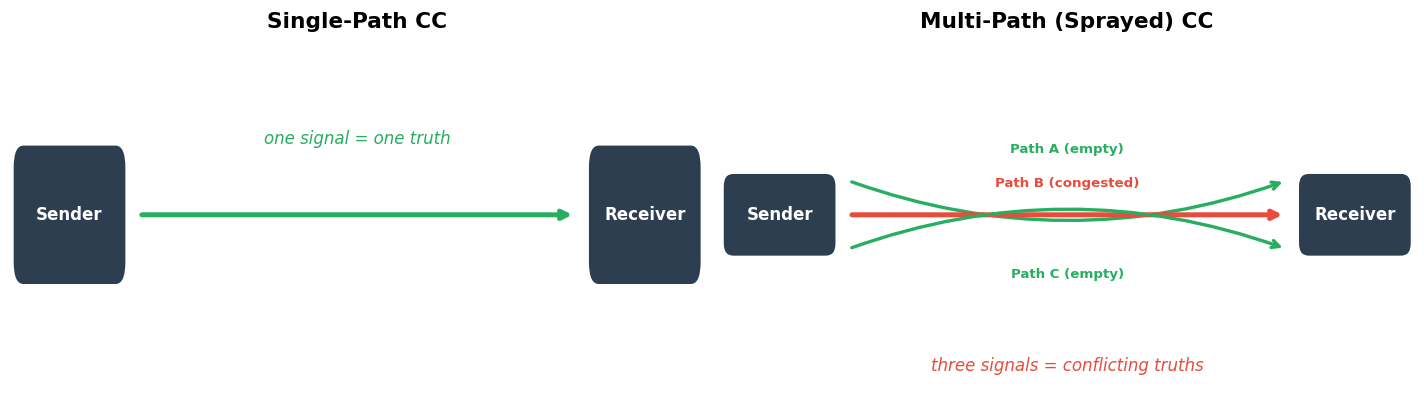

In [16]:
# ── Figure 1: Single-path vs Multi-path ──────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3.5))

def draw_node(ax, xy, label, color='#2c3e50'):
    ax.add_patch(FancyBboxPatch((xy[0]-0.08, xy[1]-0.04), 0.16, 0.08,
                 boxstyle="round,pad=0.02", facecolor=color, edgecolor='white', linewidth=2))
    ax.text(xy[0], xy[1], label, ha='center', va='center', fontsize=10,
            fontweight='bold', color='white')

# ── Left: single path ──
ax1.set_xlim(-0.1, 1.1); ax1.set_ylim(-0.15, 0.15)
draw_node(ax1, (0.0, 0.0), 'Sender')
draw_node(ax1, (1.0, 0.0), 'Receiver')
ax1.annotate('', xy=(0.88, 0.0), xytext=(0.12, 0.0),
             arrowprops=dict(arrowstyle='->', lw=3, color='#27ae60'))
ax1.text(0.5, 0.06, 'one signal = one truth', ha='center', fontsize=10,
         style='italic', color='#27ae60')
ax1.set_title('Single-Path CC', fontsize=13, fontweight='bold')
ax1.axis('off')

# ── Right: multi-path ──
ax2.set_xlim(-0.1, 1.1); ax2.set_ylim(-0.25, 0.25)
draw_node(ax2, (0.0, 0.0), 'Sender')
draw_node(ax2, (1.0, 0.0), 'Receiver')
paths = [('Path A (empty)',   0.12, '#27ae60', 2),
         ('Path B (congested)', 0.0, '#e74c3c', 3),
         ('Path C (empty)',  -0.12, '#27ae60', 2)]
for label, y, color, lw in paths:
    ax2.annotate('', xy=(0.88, y*0.4), xytext=(0.12, y*0.4),
                 arrowprops=dict(arrowstyle='->', lw=lw, color=color,
                                 connectionstyle=f'arc3,rad={y*1.5}'))
    ax2.text(0.5, y*0.4 + 0.04*np.sign(y+0.01), label, ha='center', fontsize=8,
             color=color, fontweight='bold')
ax2.text(0.5, -0.22, 'three signals = conflicting truths', ha='center',
         fontsize=10, style='italic', color='#e74c3c')
ax2.set_title('Multi-Path (Sprayed) CC', fontsize=13, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()

### NSCC's Answer: Two Signals

NSCC uses **two orthogonal signals** to disambiguate:

| Signal | What it tells you | Granularity |
|--------|-------------------|-------------|
| **Queuing delay** (RTT − base RTT) | *How much* congestion on average | Aggregate across all paths |
| **ECN marks** | *Whether a specific switch/path* is congested | Per-path |

The combination lets you distinguish **"one path is hot"** from **"the whole network is overloaded."**

**How NSCC differs from other algorithms:**

| | NSCC | TCP Cubic | DCQCN |
|---|---|---|---|
| **Type** | Window, delay+ECN | Window, loss-based | Rate, ECN via CNP |
| **Designed for** | Multi-path, shallow buffers | Single-path, deep buffers | Lossless RDMA (PFC) |
| **Source** | `uec.cpp` | `tcpcubic.cpp` | `dcqcn.cpp` |

---
## 2. The Four Quadrants — Discovering the Decision Matrix

Let's **design** a congestion control algorithm from scratch for a spraying network.
We'll start with the simplest approach and see where it breaks.

### Attempt 1: Use delay only

We measure queuing delay on every ACK. Above target → decrease. Below → increase.

With 16 paths and only Path 5 congested (20 µs), the average delay is:

$$\bar{d} = \frac{15 \times 2\,\mu s + 1 \times 20\,\mu s}{16} = 3.1\,\mu s$$

If target = 6 µs → average is **below** target → **increase!** But get three Path-5 packets in a row
and the running average jumps above target → **decrease!** The result: **oscillation driven by sampling noise**.

### Attempt 2: Add ECN as a second signal

ECN marks tell us something delay doesn't: *a specific switch on a specific path* decided it was congested.

Two binary signals → **four combinations**. Let's work through each:

1. **Low delay, no ECN** → network is uncongested → **increase** (proportionally to headroom)
2. **High delay, ECN** → congested and marking us → **decrease** (proportionally to severity)
3. **Low delay, ECN** → *this is the spraying insight* — one path is hot but average is fine → **NOOP** (just switch path)
4. **High delay, no ECN** → fair-share equilibrium → **conservative increase** (maintain share)

We didn't *invent* four quadrants — we **discovered** them.

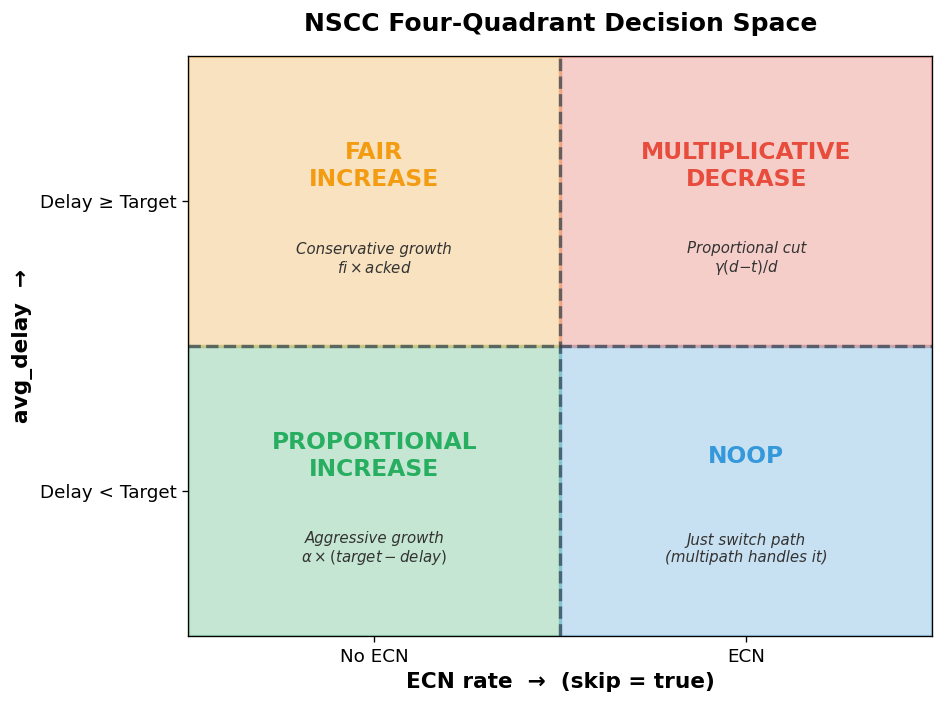

In [17]:
# ── Figure 2: Four-Quadrant Phase Space ──────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6))

colors = {
    'prop_inc':  '#27ae60',  # green
    'fair_inc':  '#f39c12',  # amber
    'mult_dec':  '#e74c3c',  # red
    'noop':      '#3498db',  # blue
}

# Draw quadrants
rects = [
    (0,   0,   0.5, 0.5, colors['prop_inc'],  'PROPORTIONAL\nINCREASE',
     'Aggressive growth\n$\\alpha \\times (target - delay)$'),
    (0.5, 0,   0.5, 0.5, colors['noop'],       'NOOP',
     'Just switch path\n(multipath handles it)'),
    (0,   0.5, 0.5, 0.5, colors['fair_inc'],   'FAIR\nINCREASE',
     'Conservative growth\n$fi \\times acked$'),
    (0.5, 0.5, 0.5, 0.5, colors['mult_dec'],   'MULTIPLICATIVE\nDECRASE',
     'Proportional cut\n$\\gamma(d{-}t)/d$'),
]

for x, y, w, h, color, label, desc in rects:
    ax.add_patch(plt.Rectangle((x, y), w, h, facecolor=color, alpha=0.25, edgecolor=color, lw=2))
    ax.text(x + w/2, y + h/2 + 0.06, label, ha='center', va='center',
            fontsize=14, fontweight='bold', color=color)
    ax.text(x + w/2, y + h/2 - 0.1, desc, ha='center', va='center',
            fontsize=9, color='#333', style='italic')

# Axes
ax.axhline(0.5, color='#2c3e50', lw=2, ls='--', alpha=0.7)
ax.axvline(0.5, color='#2c3e50', lw=2, ls='--', alpha=0.7)
ax.set_xlim(0, 1); ax.set_ylim(0, 1)
ax.set_xlabel('ECN rate  →  (skip = true)', fontsize=13, fontweight='bold')
ax.set_ylabel('avg_delay  →', fontsize=13, fontweight='bold')
ax.set_xticks([0.25, 0.75]); ax.set_xticklabels(['No ECN', 'ECN'], fontsize=11)
ax.set_yticks([0.25, 0.75]); ax.set_yticklabels(['Delay < Target', 'Delay ≥ Target'], fontsize=11)
ax.set_title('NSCC Four-Quadrant Decision Space', fontsize=15, fontweight='bold', pad=15)
ax.grid(False)

plt.tight_layout()
plt.show()

### Implementation (`uec.cpp:1310-1335`)

```cpp
if (quick_adapt fires) → return early
if (!ecn && delay >= target) → fair_increase
if (!ecn && delay <  target) → proportional_increase
if ( ecn && delay >= target) → multiplicative_decrease
if ( ecn && delay <  target) → NOOP
```

The **NOOP quadrant** is NSCC's key innovation for spraying: when ECN says "this path is bad"
but delay says "overall things are fine," the right response is to **steer traffic away from that
path** without reducing the sending rate.

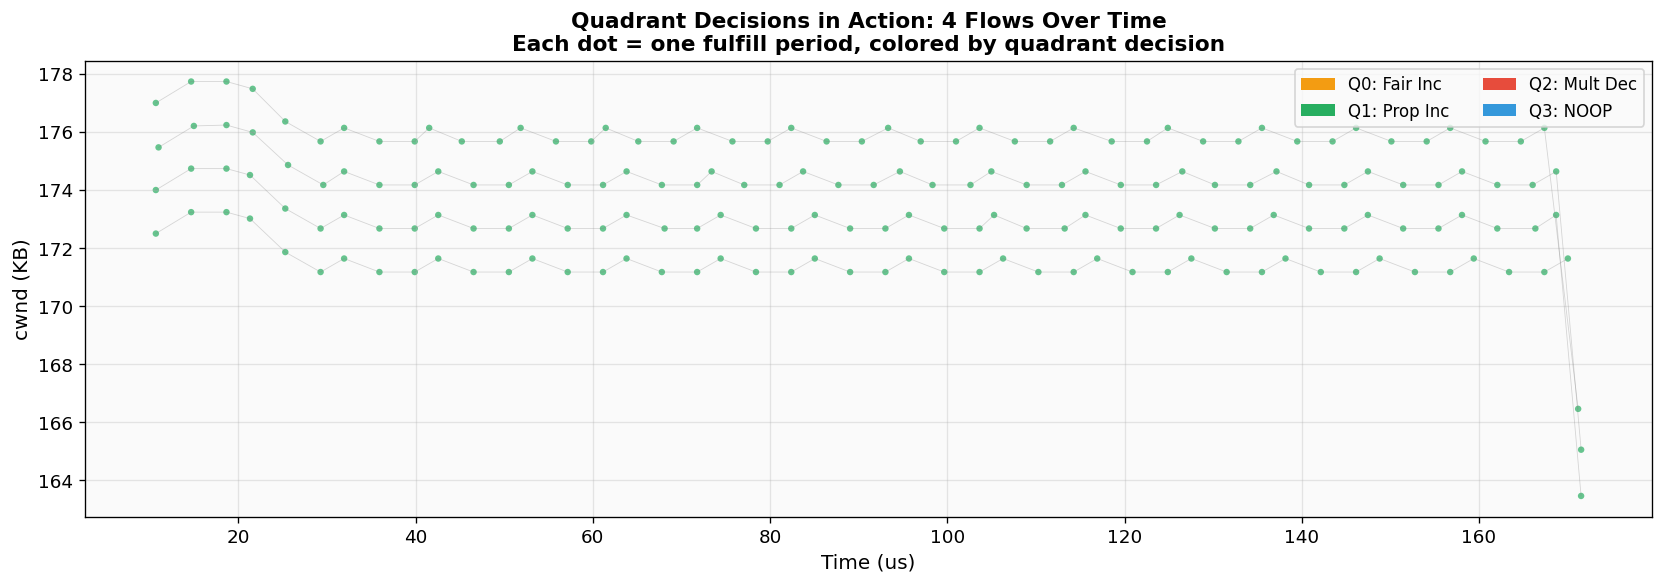

Saved: figures/sim_quadrant_timeseries.png


In [18]:
# ── Simulation Figure: Quadrant Decisions Over Time (Phase 2) ────────────────
import pandas as pd
from pathlib import Path

RESULTS = Path("results/deep_dive")
FIGURES = Path("figures")
FIGURES.mkdir(parents=True, exist_ok=True)

trace_quad_path = RESULTS / "trace_quadrant" / "quadrant_4f_trace.csv"

if trace_quad_path.exists():
    tdf_q = pd.read_csv(trace_quad_path)
    regular_q = tdf_q[tdf_q['quadrant'] != 5]  # filter out QA events

    fig, ax = plt.subplots(figsize=(14, 5))

    q_colors_map = {0: '#f39c12', 1: '#27ae60', 2: '#e74c3c', 3: '#3498db'}
    q_names = {0: 'Q0: Fair Inc', 1: 'Q1: Prop Inc', 2: 'Q2: Mult Dec', 3: 'Q3: NOOP'}

    flow_ids_q = sorted(regular_q['flow_id'].unique())[:4]
    offsets = {fid: i * 0.15 for i, fid in enumerate(flow_ids_q)}

    for fid in flow_ids_q:
        fdata = regular_q[regular_q['flow_id'] == fid]
        # Plot cwnd as a line
        ax.plot(fdata['time_us'], fdata['cwnd'] / 1024 + offsets[fid] * 10,
                color='gray', lw=0.5, alpha=0.3)
        # Scatter colored by quadrant
        for q in range(4):
            qdata = fdata[fdata['quadrant'] == q]
            if len(qdata) > 0:
                ax.scatter(qdata['time_us'], qdata['cwnd'] / 1024 + offsets[fid] * 10,
                           c=q_colors_map[q], s=15, alpha=0.7, edgecolors='none')

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=q_colors_map[q], label=q_names[q]) for q in range(4)]
    ax.legend(handles=legend_elements, fontsize=10, loc='upper right', ncol=2)

    ax.set_xlabel('Time (us)', fontsize=12)
    ax.set_ylabel('cwnd (KB)', fontsize=12)
    ax.set_title('Quadrant Decisions in Action: 4 Flows Over Time\n'
                 'Each dot = one fulfill period, colored by quadrant decision',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(FIGURES / 'sim_quadrant_timeseries.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: figures/sim_quadrant_timeseries.png")
else:
    print(f"Trace data not found at {trace_quad_path}")
    print("Run: python3 run_nscc_experiments.py -e trace_quadrant")

---
## 3. Window Management — Designing the Functions

### BDP and Maximum Window

$$\text{BDP} = \text{base\_RTT} \times \frac{\text{linkspeed}}{8} \qquad \text{maxwnd} = 1.5 \times \text{BDP}$$

The 1.5× headroom above BDP lets the window absorb transient queuing without hitting the ceiling.
(`uec.h:184`, `uec.cpp:166`)

### What Shape Should the Increase Function Have?

We need to increase the window when delay is below target. But **how aggressively?**
Let's try three approaches and see which one works.

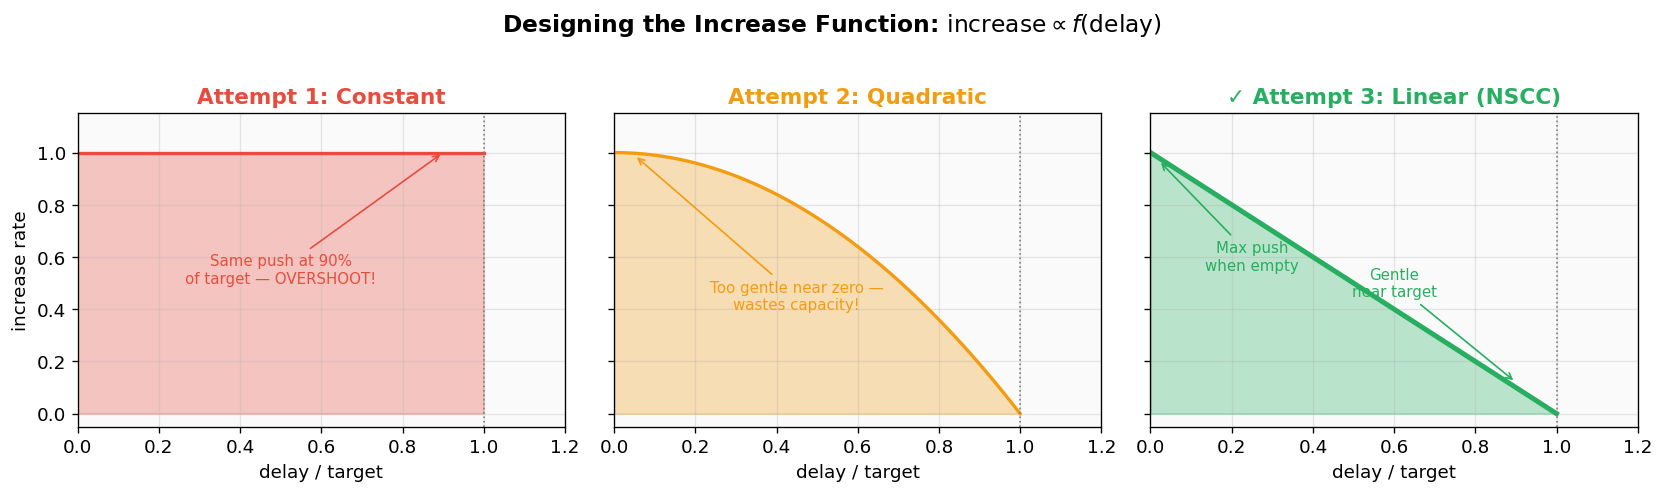

In [19]:
# ── Figure 3: Three candidate increase functions ─────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
delay = np.linspace(0, 1, 200)  # normalized: 0 = no delay, 1 = target

# Attempt 1: Constant
ax = axes[0]
inc = np.ones_like(delay)
inc[delay > 1] = 0
ax.fill_between(delay, inc, alpha=0.3, color='#e74c3c')
ax.plot(delay, inc, color='#e74c3c', lw=2)
ax.set_title('Attempt 1: Constant', fontweight='bold', color='#e74c3c')
ax.annotate('Same push at 90%\nof target — OVERSHOOT!',
            xy=(0.9, 1.0), xytext=(0.5, 0.5),
            fontsize=9, ha='center', color='#e74c3c',
            arrowprops=dict(arrowstyle='->', color='#e74c3c'))
ax.set_xlabel('delay / target')
ax.set_ylabel('increase rate')

# Attempt 2: Quadratic
ax = axes[1]
inc = np.maximum(1 - delay**2, 0)
ax.fill_between(delay, inc, alpha=0.3, color='#f39c12')
ax.plot(delay, inc, color='#f39c12', lw=2)
ax.set_title('Attempt 2: Quadratic', fontweight='bold', color='#f39c12')
ax.annotate('Too gentle near zero —\nwastes capacity!',
            xy=(0.05, 0.99), xytext=(0.45, 0.4),
            fontsize=9, ha='center', color='#f39c12',
            arrowprops=dict(arrowstyle='->', color='#f39c12'))
ax.set_xlabel('delay / target')

# Attempt 3: Linear (NSCC's choice)
ax = axes[2]
inc = np.maximum(1 - delay, 0)
ax.fill_between(delay, inc, alpha=0.3, color='#27ae60')
ax.plot(delay, inc, color='#27ae60', lw=3)
ax.set_title('✓ Attempt 3: Linear (NSCC)', fontweight='bold', color='#27ae60')
ax.annotate('Max push\nwhen empty', xy=(0.02, 0.97), xytext=(0.25, 0.55),
            fontsize=9, ha='center', color='#27ae60',
            arrowprops=dict(arrowstyle='->', color='#27ae60'))
ax.annotate('Gentle\nnear target', xy=(0.9, 0.12), xytext=(0.6, 0.45),
            fontsize=9, ha='center', color='#27ae60',
            arrowprops=dict(arrowstyle='->', color='#27ae60'))
ax.set_xlabel('delay / target')

for ax in axes:
    ax.set_xlim(0, 1.2); ax.set_ylim(-0.05, 1.15)
    ax.axvline(1.0, color='gray', ls=':', lw=1, label='target')

fig.suptitle('Designing the Increase Function: $\\mathrm{increase} \\propto f(\\mathrm{delay})$',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

The **linear ramp** is the Goldilocks choice:
- Maximum aggressiveness when the network is empty (delay ≈ 0)
- Gentle approach as we near target (no overshoot)
- Zero increase *exactly at target* (smooth transition to fair_increase)

This is NSCC's proportional increase: $\;\Delta w \propto \alpha \times (\text{target} - \text{delay})$

### Four Tiers of Increase

| Tier | When | Formula | Applied to |
|------|------|---------|------------|
| **fast_increase** | delay < 1µs for full cwnd | `cwnd += acked × fi_scale` | `_cwnd` directly |
| **proportional_increase** | delay < target, no ECN | `inc_bytes += α × acked × (target − delay)` | accumulator |
| **fair_increase** | delay ≥ target, no ECN | `inc_bytes += fi × acked` | accumulator |
| **eta** | every adjustment period | `cwnd += η` | `_cwnd` directly |

Source: `uec.cpp:1202-1238`

### Designing the Decrease Function

When we need to decrease, **how much should we cut?**

TCP uses a fixed cut (β = 0.7): always keep 70%. But this ignores *severity* — barely above target
gets the same cut as 10× above target.

NSCC's approach: make the cut **proportional to excess delay**:

$$\text{kept} = \max\!\left(1 - \gamma \cdot \frac{d - t}{d},\; 0.5\right)$$

where $d$ = avg\_delay, $t$ = target, $\gamma = 0.8$. The floor at 0.5 prevents cutting more than half.

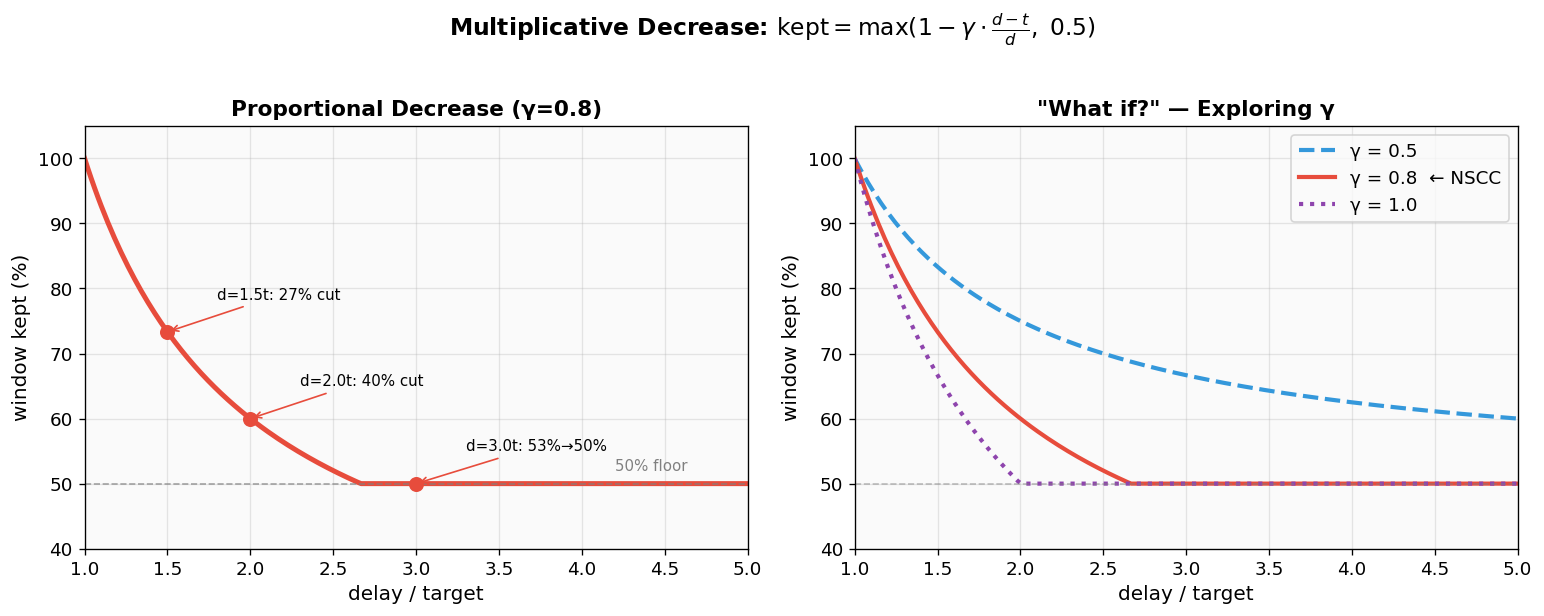

In [20]:
# ── Figure 4: Decrease function — sensitivity to delay and gamma ─────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

d_over_t = np.linspace(1.0, 5.0, 200)  # delay / target

# Left: window kept vs delay/target for gamma=0.8
gamma = 0.8
kept = np.maximum(1 - gamma * (d_over_t - 1) / d_over_t, 0.5) * 100
ax1.plot(d_over_t, kept, color='#e74c3c', lw=3, label=f'γ = {gamma} (NSCC)')
ax1.axhline(50, color='gray', ls='--', lw=1, alpha=0.7)
ax1.text(4.2, 52, '50% floor', fontsize=9, color='gray')
# Annotate key points
for d, label in [(1.5, '27% cut'), (2.0, '40% cut'), (3.0, '53%→50%')]:
    k = max(1 - gamma * (d - 1) / d, 0.5) * 100
    ax1.plot(d, k, 'o', color='#e74c3c', markersize=8, zorder=5)
    ax1.annotate(f'd={d:.1f}t: {label}', xy=(d, k), xytext=(d+0.3, k+5),
                 fontsize=9, arrowprops=dict(arrowstyle='->', color='#e74c3c'))
ax1.set_xlabel('delay / target', fontsize=12)
ax1.set_ylabel('window kept (%)', fontsize=12)
ax1.set_title('Proportional Decrease (γ=0.8)', fontsize=13, fontweight='bold')
ax1.set_ylim(40, 105); ax1.set_xlim(1, 5)

# Right: comparing gamma values
for gamma, color, ls in [(0.5, '#3498db', '--'), (0.8, '#e74c3c', '-'), (1.0, '#8e44ad', ':')]:
    kept = np.maximum(1 - gamma * (d_over_t - 1) / d_over_t, 0.5) * 100
    label_str = f'γ = {gamma}'
    if gamma == 0.8:
        label_str += '  ← NSCC'
    ax2.plot(d_over_t, kept, color=color, lw=2.5, ls=ls, label=label_str)

ax2.axhline(50, color='gray', ls='--', lw=1, alpha=0.5)
ax2.legend(fontsize=11, loc='upper right')
ax2.set_xlabel('delay / target', fontsize=12)
ax2.set_ylabel('window kept (%)', fontsize=12)
ax2.set_title('"What if?" — Exploring γ', fontsize=13, fontweight='bold')
ax2.set_ylim(40, 105); ax2.set_xlim(1, 5)

fig.suptitle('Multiplicative Decrease: $\\mathrm{kept} = \\max(1 - \\gamma \\cdot \\frac{d-t}{d},\\; 0.5)$',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Why γ = 0.8?** It's aggressive enough to respond quickly to real congestion,
but leaves enough headroom below the 50% floor that moderate congestion (d = 1.5t)
doesn't slam into the hard limit. At d = 2t, we keep 60% — a meaningful but not devastating cut.

**Implementation** (`uec.cpp:1240-1255`):
```cpp
avg_delay = get_avg_delay();
if (avg_delay > _target_Qdelay) {
    if (now - _last_dec_time > _base_rtt) {           // once per RTT
        _cwnd *= max(1 - _gamma * (avg_delay - _target_Qdelay) / avg_delay, 0.5);
    }
}
```

### The Fulfill Adjustment: Batched Window Updates

NSCC doesn't apply increments on every ACK. Instead it uses a **two-phase approach**:

1. **Accumulate** signals from many ACKs into `_inc_bytes`
2. **Apply** one normalized adjustment periodically: `cwnd += inc_bytes / cwnd`

The division by `cwnd` is the key to fairness:

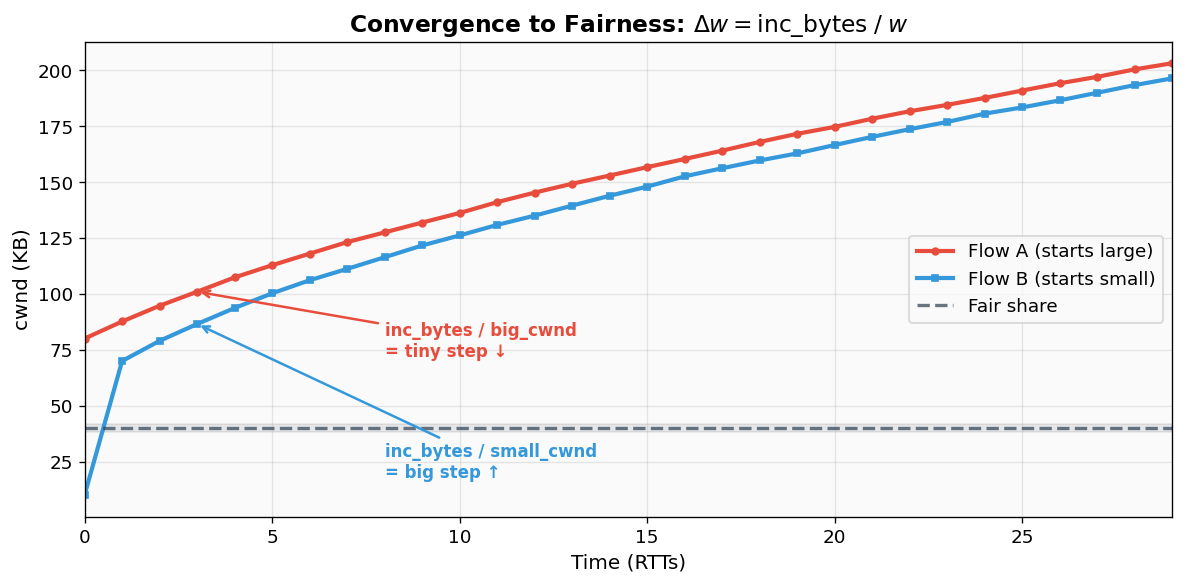

In [21]:
# ── Figure 5: Convergence to fairness via cwnd normalization ─────────────────
fig, ax = plt.subplots(figsize=(10, 5))

np.random.seed(42)
n_rtts = 30
fair_share = 40  # KB

# Simulate two flows converging
cwnd_a = np.zeros(n_rtts)  # starts big
cwnd_b = np.zeros(n_rtts)  # starts small
cwnd_a[0] = 80
cwnd_b[0] = 10
inc_bytes = 600  # KB (same raw accumulation for both)

for i in range(1, n_rtts):
    # cwnd += inc_bytes / cwnd (normalized increase)
    cwnd_a[i] = cwnd_a[i-1] + inc_bytes / cwnd_a[i-1] + np.random.normal(0, 0.3)
    cwnd_b[i] = cwnd_b[i-1] + inc_bytes / cwnd_b[i-1] + np.random.normal(0, 0.3)
    # Clamp
    cwnd_a[i] = max(cwnd_a[i], 5)
    cwnd_b[i] = max(cwnd_b[i], 5)

rtts = np.arange(n_rtts)
ax.plot(rtts, cwnd_a, color='#e74c3c', lw=2.5, label='Flow A (starts large)', marker='o', markersize=4)
ax.plot(rtts, cwnd_b, color='#3498db', lw=2.5, label='Flow B (starts small)', marker='s', markersize=4)
ax.axhline(fair_share, color='#2c3e50', ls='--', lw=2, alpha=0.7, label='Fair share')
ax.fill_between(rtts, fair_share-2, fair_share+2, alpha=0.1, color='#2c3e50')

# Annotate the mechanism
ax.annotate('inc_bytes / big_cwnd\n= tiny step ↓',
            xy=(3, cwnd_a[3]), xytext=(8, 72),
            fontsize=10, color='#e74c3c', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=1.5))
ax.annotate('inc_bytes / small_cwnd\n= big step ↑',
            xy=(3, cwnd_b[3]), xytext=(8, 18),
            fontsize=10, color='#3498db', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='#3498db', lw=1.5))

ax.set_xlabel('Time (RTTs)', fontsize=12)
ax.set_ylabel('cwnd (KB)', fontsize=12)
ax.set_title('Convergence to Fairness: $\\Delta w = \\mathrm{inc\\_bytes} \\;/\\; w$',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='right')
ax.set_xlim(0, n_rtts-1)
plt.tight_layout()
plt.show()

### Fulfill Trigger Conditions (`uec.cpp:1341`)

The batch fires when **either** condition is met:
- **Byte trigger**: `received_bytes > 8 × MTU` (≈ 32 KB)
- **Time trigger**: `now − last_adjust_time > network_RTT`

```
ACK 1:  _inc_bytes += 30000     (cwnd unchanged)
ACK 2:  _inc_bytes += 28000     (cwnd unchanged)
...
ACK 8:  received_bytes crosses 8×MTU
        → fulfill_adjustment():
           cwnd += inc_bytes / cwnd    (normalized)
           cwnd += eta                 (small bonus)
           reset accumulators
```

### Window Bounds
```cpp
if (_cwnd < _min_cwnd) _cwnd = _min_cwnd;   // 1 MTU
if (_cwnd > _maxwnd)   _cwnd = _maxwnd;      // 1.5 × BDP
```

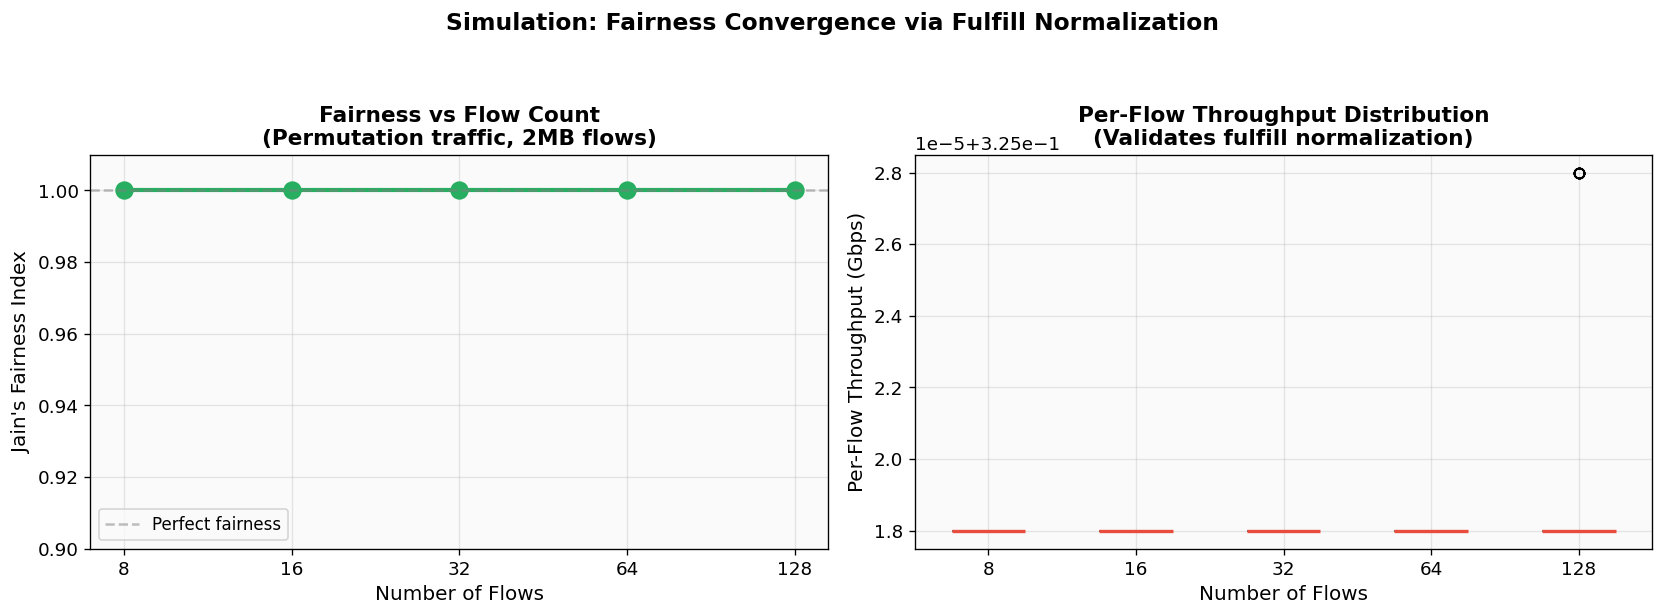

Saved: figures/sim_fairness.png


In [22]:
# ── Simulation Figure: Fairness Convergence ──────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

flow_counts = [8, 16, 32, 64, 128]
jains_fi, mean_tputs_f = [], []

for nf in flow_counts:
    csv_path = RESULTS / "fairness" / f"fairness_{nf}f.csv"
    if not csv_path.exists():
        jains_fi.append(np.nan); mean_tputs_f.append(np.nan)
        continue
    df = pd.read_csv(csv_path)
    tputs = df[df['throughput_gbps'] > 0]['throughput_gbps'].values
    if len(tputs) > 1:
        jains_fi.append((tputs.sum()**2) / (len(tputs) * (tputs**2).sum()))
    else:
        jains_fi.append(np.nan)
    mean_tputs_f.append(tputs.mean() if len(tputs) > 0 else 0)

# Left: Jain's FI vs flow count
ax1.plot(flow_counts, jains_fi, 'o-', color='#27ae60', lw=2.5, markersize=10)
ax1.axhline(1.0, color='gray', ls='--', alpha=0.5, label='Perfect fairness')
ax1.set_xlabel('Number of Flows', fontsize=12)
ax1.set_ylabel("Jain's Fairness Index", fontsize=12)
ax1.set_title("Fairness vs Flow Count\n(Permutation traffic, 2MB flows)",
              fontsize=13, fontweight='bold')
ax1.set_ylim(0.9, 1.01)
ax1.set_xscale('log', base=2)
ax1.set_xticks(flow_counts)
ax1.set_xticklabels(flow_counts)
ax1.legend(fontsize=10)

# Right: Per-flow throughput box plots
box_data = []
box_labels = []
for nf in flow_counts:
    csv_path = RESULTS / "fairness" / f"fairness_{nf}f.csv"
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        tputs = df[df['throughput_gbps'] > 0]['throughput_gbps'].values
        box_data.append(tputs)
        box_labels.append(str(nf))
    else:
        box_data.append([])
        box_labels.append(str(nf))

bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True,
                 boxprops=dict(facecolor='#3498db', alpha=0.6),
                 medianprops=dict(color='#e74c3c', lw=2))
ax2.set_xlabel('Number of Flows', fontsize=12)
ax2.set_ylabel('Per-Flow Throughput (Gbps)', fontsize=12)
ax2.set_title('Per-Flow Throughput Distribution\n(Validates fulfill normalization)',
              fontsize=13, fontweight='bold')

fig.suptitle('Simulation: Fairness Convergence via Fulfill Normalization',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES / 'sim_fairness.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: figures/sim_fairness.png")

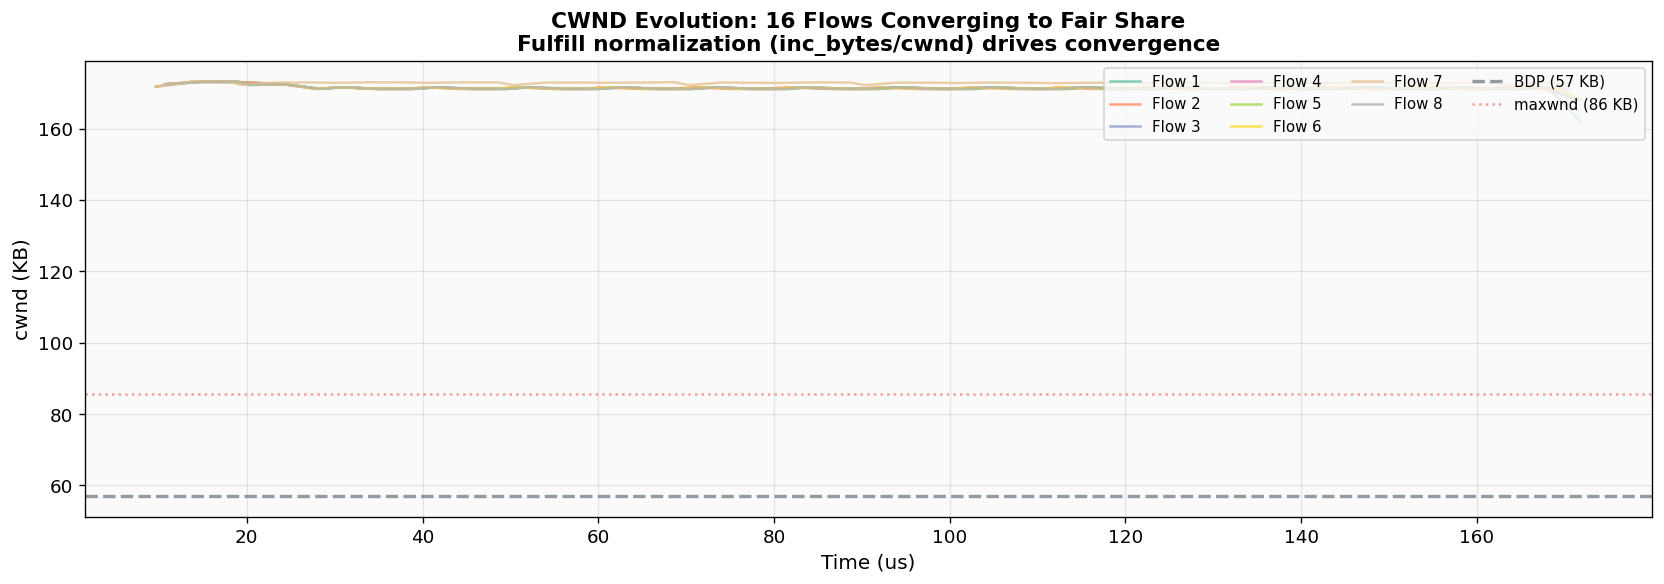

Saved: figures/sim_cwnd_evolution.png


In [23]:
# ── Simulation Figure: CWND Evolution Time-Series (Phase 2) ──────────────────
trace_cwnd_path = RESULTS / "trace_cwnd" / "cwnd_16f_trace.csv"

if trace_cwnd_path.exists():
    tdf_c = pd.read_csv(trace_cwnd_path)
    regular_c = tdf_c[tdf_c['quadrant'] != 5]

    fig, ax = plt.subplots(figsize=(14, 5))

    flow_ids_c = sorted(regular_c['flow_id'].unique())[:8]
    cmap_c = plt.cm.Set2

    for i, fid in enumerate(flow_ids_c):
        fdata_c = regular_c[regular_c['flow_id'] == fid]
        ax.plot(fdata_c['time_us'], fdata_c['cwnd'] / 1024,
                color=cmap_c(i), lw=1.5, alpha=0.8, label=f'Flow {fid}')

    # Show BDP reference if available
    if 'bdp' in regular_c.columns and regular_c['bdp'].iloc[0] > 0:
        bdp_val = regular_c['bdp'].iloc[0]
        ax.axhline(bdp_val / 1024, color='#2c3e50', ls='--', lw=2,
                   alpha=0.5, label=f'BDP ({bdp_val/1024:.0f} KB)')
        ax.axhline(1.5 * bdp_val / 1024, color='#e74c3c', ls=':', lw=1.5,
                   alpha=0.5, label=f'maxwnd ({1.5*bdp_val/1024:.0f} KB)')

    ax.set_xlabel('Time (us)', fontsize=12)
    ax.set_ylabel('cwnd (KB)', fontsize=12)
    ax.set_title('CWND Evolution: 16 Flows Converging to Fair Share\n'
                 'Fulfill normalization (inc_bytes/cwnd) drives convergence',
                 fontsize=13, fontweight='bold')
    ax.legend(fontsize=9, ncol=4, loc='upper right')
    plt.tight_layout()
    plt.savefig(FIGURES / 'sim_cwnd_evolution.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: figures/sim_cwnd_evolution.png")
else:
    print(f"Trace data not found at {trace_cwnd_path}")
    print("Run: python3 run_nscc_experiments.py -e trace_cwnd")

---
## 4. Delay Measurement & Filtering — A Trustworthy Thermometer

NSCC's decisions depend on accurate delay measurement. But in a spraying network, each ACK's
delay comes from a **different path**. How do you build a signal that reflects *overall* network
state rather than per-path noise?

### Queuing delay extraction

$$\text{delay} = \text{raw\_RTT} - \text{base\_RTT}$$

where `base_RTT` is the running minimum over all RTT samples — a proxy for pure propagation delay.
(`uec.cpp:973`, `uec.cpp:1389-1400`)

### Why such a slow EWMA?

NSCC uses $\alpha_{\text{ewma}} = 0.0125$ — that's **1/80**. An extremely slow filter.
Let's see what happens with a faster one:

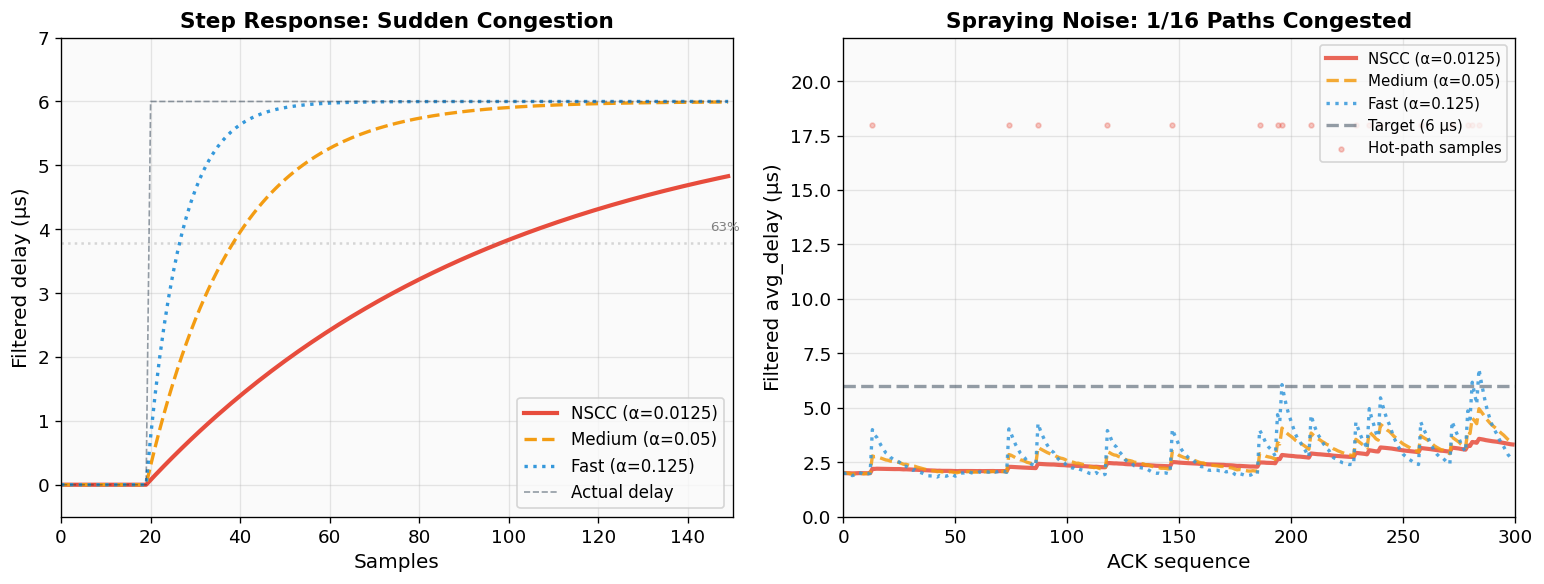

In [24]:
# ── Figure 6: EWMA step response — slow vs fast filter ───────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

n_samples = 150
step_at = 20
actual = np.zeros(n_samples)
actual[step_at:] = 6.0  # step from 0 to 6 µs

alphas = [
    (0.0125, 'NSCC (α=0.0125)', '#e74c3c', '-',  2.5),
    (0.05,   'Medium (α=0.05)',  '#f39c12', '--', 2),
    (0.125,  'Fast (α=0.125)',   '#3498db', ':',  2),
]

# Left: step response
for a, label, color, ls, lw in alphas:
    avg = np.zeros(n_samples)
    for i in range(1, n_samples):
        avg[i] = a * actual[i] + (1 - a) * avg[i-1]
    ax1.plot(avg, color=color, ls=ls, lw=lw, label=label)

ax1.plot(actual, color='#2c3e50', lw=1, ls='--', alpha=0.5, label='Actual delay')
ax1.axhline(6*0.63, color='gray', ls=':', alpha=0.3)
ax1.text(145, 6*0.63+0.2, '63%', fontsize=8, color='gray')
ax1.set_xlabel('Samples', fontsize=12)
ax1.set_ylabel('Filtered delay (µs)', fontsize=12)
ax1.set_title('Step Response: Sudden Congestion', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.set_xlim(0, n_samples)
ax1.set_ylim(-0.5, 7)

# Right: noisy spraying scenario — 1/16 paths congested
np.random.seed(123)
n = 300
path_congested = np.random.random(n) < (1/16)  # 1 in 16 packets from hot path
delay_samples = np.where(path_congested, 18.0, np.random.normal(2.0, 0.3, n))
delay_samples = np.maximum(delay_samples, 0)

target = 6.0
for a, label, color, ls, lw in alphas:
    avg = np.zeros(n)
    avg[0] = 2.0
    for i in range(1, n):
        avg[i] = a * delay_samples[i] + (1 - a) * avg[i-1]
    ax2.plot(avg, color=color, ls=ls, lw=lw, label=label, alpha=0.85)

ax2.axhline(target, color='#2c3e50', ls='--', lw=2, alpha=0.5, label='Target (6 µs)')
ax2.scatter(np.where(path_congested)[0],
            delay_samples[path_congested],
            s=8, color='#e74c3c', alpha=0.3, zorder=0, label='Hot-path samples')
ax2.set_xlabel('ACK sequence', fontsize=12)
ax2.set_ylabel('Filtered avg_delay (µs)', fontsize=12)
ax2.set_title('Spraying Noise: 1/16 Paths Congested', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9, loc='upper right')
ax2.set_xlim(0, n); ax2.set_ylim(0, 22)

plt.tight_layout()
plt.show()

The fast filter (α=0.125) **thrashes** — every time a hot-path sample arrives, it spikes toward
the target, potentially triggering a decrease. Then it drops back, triggering an increase.
**Wild oscillation on every few ACKs.**

The slow NSCC filter (α=0.0125) barely moves on individual hot-path samples. It only responds
when *sustained* congestion shifts the overall average — exactly what we want.

### Three Special Cases in the Filter

The EWMA isn't applied uniformly. The filter **trusts different samples differently**:

| Sample type | What filter sees | Why |
|-------------|------------------|-----|
| **ECN + high delay** | actual delay | Switch *confirmed* congestion — trust it |
| **No ECN + high delay** | `base_rtt × 0.25` | Probably just one bad path — discount it |
| **Extreme outlier (> 5×)** | actual delay | Something seriously wrong — trust it |

Source: `uec.cpp:1402-1423`

**Case 1** is the key insight: without ECN, high delay might just be one congested path out of 16.
Feeding the real delay into the filter would inflate the average and trigger unnecessary decreases.
So we discount it to `base_rtt × 0.25` — a tiny contribution that barely moves the needle.

**Case 2** overrides Case 1: if delay exceeds 5× base RTT, something is *seriously* wrong
(failing link, major routing change) regardless of ECN status.

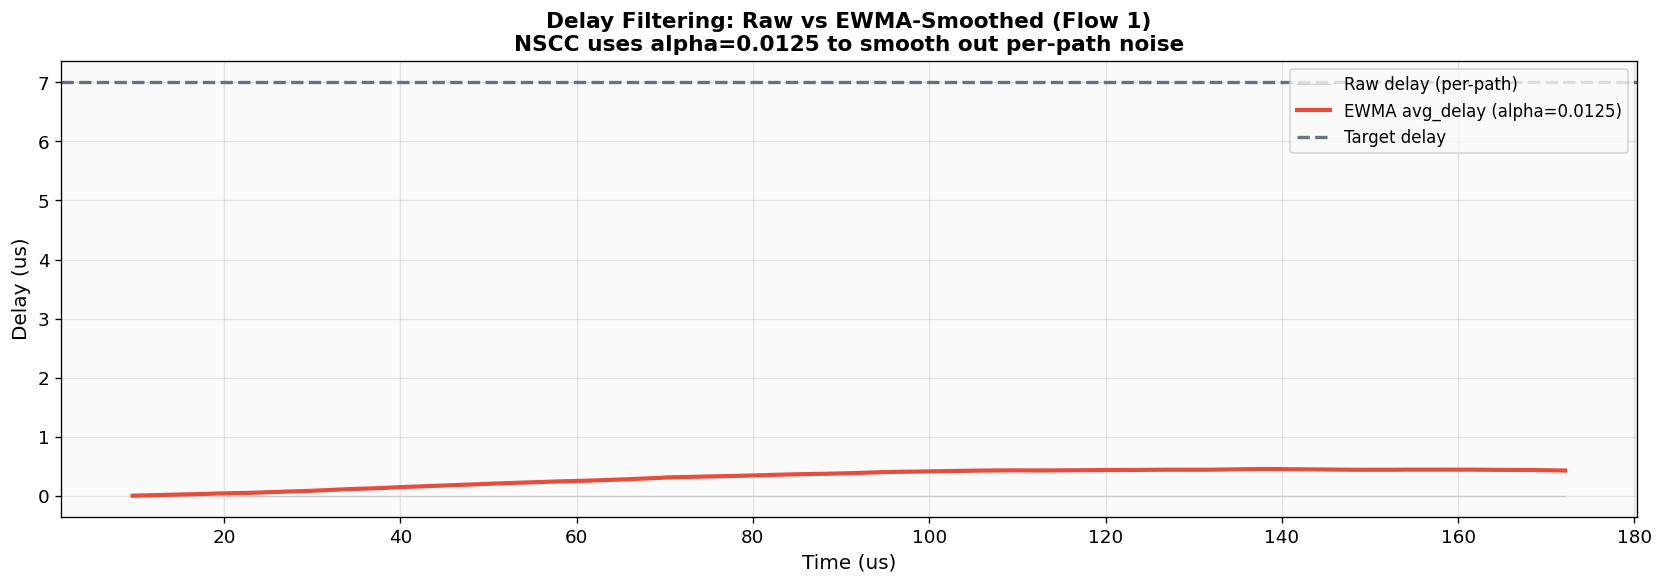

Saved: figures/sim_delay_traces.png


In [25]:
# ── Simulation Figure: Delay Traces (Phase 2) ────────────────────────────────
trace_delay_path = RESULTS / "trace_delay" / "delay_32f_trace.csv"

if trace_delay_path.exists():
    tdf_d = pd.read_csv(trace_delay_path)
    regular_d = tdf_d[tdf_d['quadrant'] != 5]

    fig, ax = plt.subplots(figsize=(14, 5))

    # Pick one flow to show raw vs avg delay
    flow_ids_d = sorted(regular_d['flow_id'].unique())
    if len(flow_ids_d) > 0:
        fid = flow_ids_d[0]
        fdata_d = regular_d[regular_d['flow_id'] == fid].copy()

        ax.plot(fdata_d['time_us'], fdata_d['raw_delay_us'],
                color='#bdc3c7', lw=0.8, alpha=0.7, label='Raw delay (per-path)')
        ax.plot(fdata_d['time_us'], fdata_d['avg_delay_us'],
                color='#e74c3c', lw=2.5, label='EWMA avg_delay (alpha=0.0125)')
        ax.axhline(fdata_d['target_us'].iloc[0] if len(fdata_d) > 0 else 0,
                   color='#2c3e50', ls='--', lw=2, alpha=0.7, label='Target delay')

        # Mark ECN events
        ecn_pts = fdata_d[fdata_d['ecn'] == 1]
        if len(ecn_pts) > 0:
            ax.scatter(ecn_pts['time_us'], ecn_pts['raw_delay_us'],
                       color='#e74c3c', marker='x', s=40, zorder=5,
                       label='ECN marked', alpha=0.6)

        ax.set_xlabel('Time (us)', fontsize=12)
        ax.set_ylabel('Delay (us)', fontsize=12)
        ax.set_title(f'Delay Filtering: Raw vs EWMA-Smoothed (Flow {fid})\n'
                     f'NSCC uses alpha=0.0125 to smooth out per-path noise',
                     fontsize=13, fontweight='bold')
        ax.legend(fontsize=10, loc='upper right')

    plt.tight_layout()
    plt.savefig(FIGURES / 'sim_delay_traces.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: figures/sim_delay_traces.png")
else:
    print(f"Trace data not found at {trace_delay_path}")
    print("Run: python3 run_nscc_experiments.py -e trace_delay")

---
## 5. Quick Adapt — The Emergency Brake

### Why Normal Decrease Isn't Enough

Multiplicative decrease cuts at most **50% per RTT**. In a 64-flow incast, fair share = 1/64 of
the pipe. Even with maximal cuts:

$$\text{RTTs to converge} = \log_2(64) \approx 6$$

During those 6 RTTs, excess packets cause severe queuing for *everyone*.

Quick Adapt doesn't *decrease* the window — it **resets** to what was actually achieved.

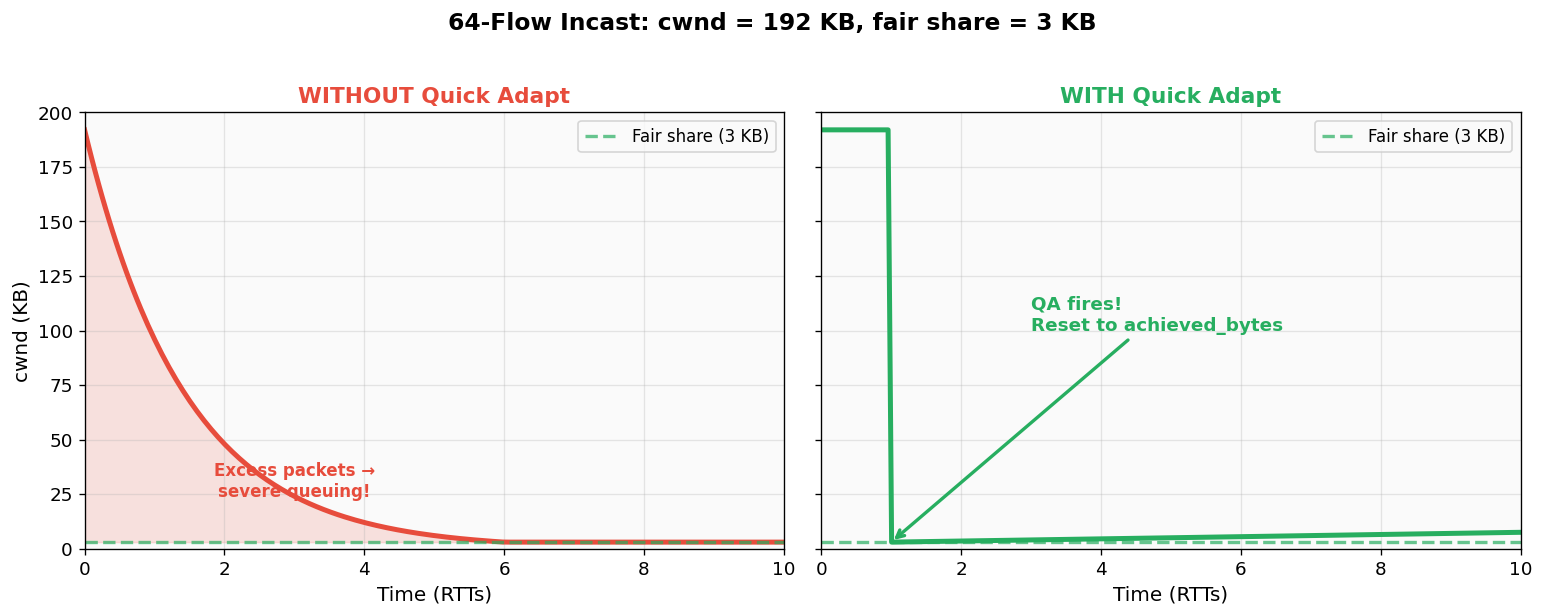

In [26]:
# ── Figure 7: Quick Adapt — before vs after ──────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

# Simulate WITHOUT Quick Adapt — iterative 50% cuts
t = np.linspace(0, 10, 200)  # RTTs
cwnd_no_qa = 192 * np.power(0.5, t)  # 50% cut each RTT
cwnd_no_qa = np.maximum(cwnd_no_qa, 3)

ax1.plot(t, cwnd_no_qa, color='#e74c3c', lw=3)
ax1.axhline(3, color='#27ae60', ls='--', lw=2, alpha=0.7, label='Fair share (3 KB)')
ax1.fill_between(t, cwnd_no_qa, 3, where=cwnd_no_qa > 3, alpha=0.15, color='#e74c3c')
ax1.annotate('Excess packets →\nsevere queuing!', xy=(3, 24), fontsize=10,
             color='#e74c3c', fontweight='bold', ha='center')
ax1.set_xlabel('Time (RTTs)', fontsize=12)
ax1.set_ylabel('cwnd (KB)', fontsize=12)
ax1.set_title('WITHOUT Quick Adapt', fontsize=13, fontweight='bold', color='#e74c3c')
ax1.legend(fontsize=10)
ax1.set_xlim(0, 10); ax1.set_ylim(0, 200)

# Simulate WITH Quick Adapt — instant reset at 1 RTT
t2 = np.linspace(0, 10, 200)
cwnd_qa = np.full_like(t2, 192.0)
qa_fires = 1.0  # fires at ~1 RTT
cwnd_qa[t2 >= qa_fires] = 3.0
# Recovery phase
recovery_mask = t2 >= qa_fires
recovery_t = t2[recovery_mask] - qa_fires
cwnd_qa[recovery_mask] = 3.0 + 0.5 * recovery_t  # gentle ramp-up

ax2.plot(t2, cwnd_qa, color='#27ae60', lw=3)
ax2.axhline(3, color='#27ae60', ls='--', lw=2, alpha=0.7, label='Fair share (3 KB)')
ax2.annotate('QA fires!\nReset to achieved_bytes',
             xy=(qa_fires, 3), xytext=(3, 100),
             fontsize=11, fontweight='bold', color='#27ae60',
             arrowprops=dict(arrowstyle='->', color='#27ae60', lw=2))
ax2.set_xlabel('Time (RTTs)', fontsize=12)
ax2.set_title('WITH Quick Adapt', fontsize=13, fontweight='bold', color='#27ae60')
ax2.legend(fontsize=10)
ax2.set_xlim(0, 10)

fig.suptitle('64-Flow Incast: cwnd = 192 KB, fair share = 3 KB',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

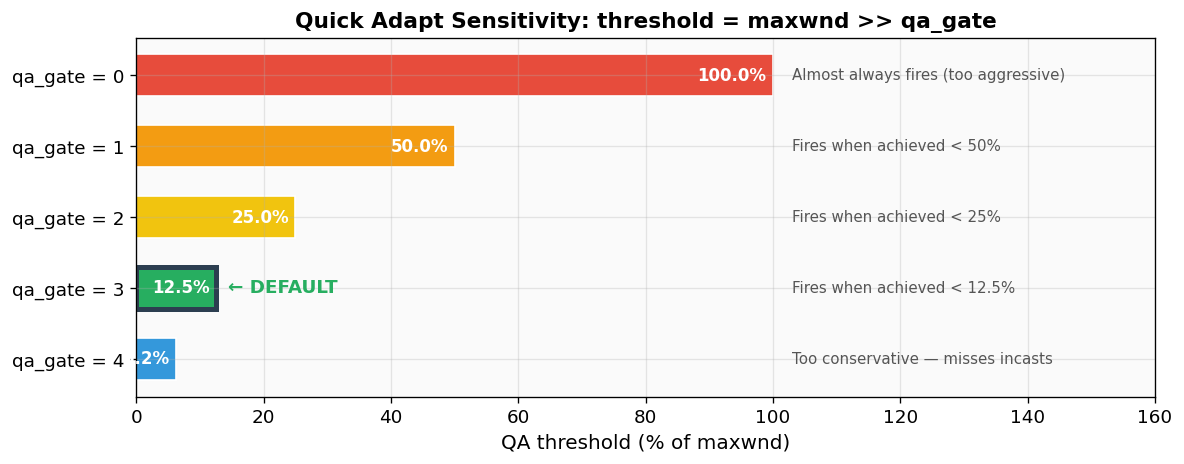

In [27]:
# ── Figure 8: qa_gate parameter exploration ──────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4))

gates = [0, 1, 2, 3, 4]
thresholds = [100 / (2**g) for g in gates]
colors_qa = ['#e74c3c', '#f39c12', '#f1c40f', '#27ae60', '#3498db']
labels = [f'qa_gate={g}\n({t:.1f}%)' for g, t in zip(gates, thresholds)]

bars = ax.barh(range(len(gates)), thresholds, color=colors_qa, edgecolor='white', height=0.6)

# Highlight default
bars[3].set_edgecolor('#2c3e50')
bars[3].set_linewidth(3)
ax.text(thresholds[3] + 2, 3, '← DEFAULT', fontsize=11, fontweight='bold',
        color='#27ae60', va='center')

for i, (g, t) in enumerate(zip(gates, thresholds)):
    ax.text(t - 1, i, f'{t:.1f}%', ha='right', va='center', fontsize=10,
            fontweight='bold', color='white')

desc = ['Almost always fires (too aggressive)',
        'Fires when achieved < 50%',
        'Fires when achieved < 25%',
        'Fires when achieved < 12.5%',
        'Too conservative — misses incasts']
for i, d in enumerate(desc):
    ax.text(max(thresholds) + 3, i, d, va='center', fontsize=9, color='#555')

ax.set_yticks(range(len(gates)))
ax.set_yticklabels([f'qa_gate = {g}' for g in gates], fontsize=11)
ax.set_xlabel('QA threshold (% of maxwnd)', fontsize=12)
ax.set_title('Quick Adapt Sensitivity: threshold = maxwnd >> qa_gate',
             fontsize=13, fontweight='bold')
ax.set_xlim(0, 160)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### Mechanism (`uec.cpp:1145-1200`)

```
Every (base_rtt + target_Qdelay) interval:
  if (trigger_qa OR loss OR delay > 4 × target)
    AND (achieved_bytes < maxwnd >> qa_gate):
      cwnd = max(achieved_bytes, min_cwnd)
```

### Ignoring Stale Feedback

After QA fires, packets already in flight return with stale feedback. QA sets
`bytes_to_ignore = in_flight` — subsequent ACKs are suppressed until the old pipeline drains.
This prevents stale signals from further reducing the window after QA has corrected it.
(`uec.cpp:1185-1186`)

### Simulation Validation: Quick Adapt & Incast Behavior

The following cells load real simulation data to validate the QA gate sensitivity, incast degree scaling, and time-series QA firing. Run `python3 run_nscc_experiments.py -e qa_gate,incast_degree,trace_qa` to generate the data.

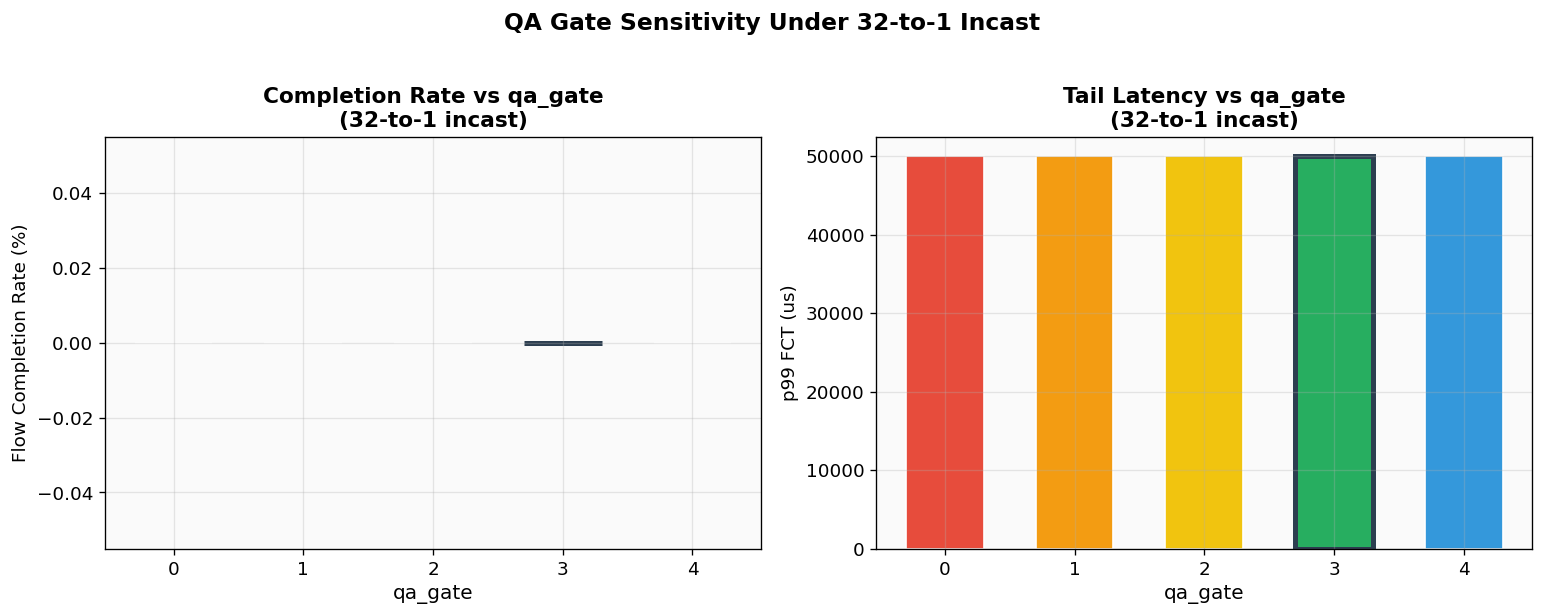

Saved: figures/sim_qa_gate.png


In [28]:
# ── Simulation Figure: QA Gate Sensitivity ───────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

qa_gates = list(range(0, 5))
completion_pcts, p99_fcts_qa = [], []

for qa in qa_gates:
    csv_path = RESULTS / "qa_gate" / f"qa_gate_{qa}.csv"
    if not csv_path.exists():
        completion_pcts.append(np.nan); p99_fcts_qa.append(np.nan)
        continue
    df = pd.read_csv(csv_path)
    sized = df[df['size_bytes'] > 0]
    completion_pcts.append(sized['finished'].mean() * 100 if len(sized) > 0 else 0)
    fcts = df[df['fct_us'] > 0]['fct_us']
    p99_fcts_qa.append(fcts.quantile(0.99) if len(fcts) > 0 else 0)

colors_qa_sim = ['#e74c3c', '#f39c12', '#f1c40f', '#27ae60', '#3498db']
bars1 = ax1.bar(qa_gates, completion_pcts, color=colors_qa_sim, edgecolor='white', width=0.6)
# Highlight default qa_gate=3
if len(bars1) > 3:
    bars1[3].set_edgecolor('#2c3e50')
    bars1[3].set_linewidth(3)
ax1.set_xlabel('qa_gate', fontsize=12)
ax1.set_ylabel('Flow Completion Rate (%)', fontsize=11)
ax1.set_title('Completion Rate vs qa_gate\n(32-to-1 incast)', fontsize=13, fontweight='bold')
ax1.set_xticks(qa_gates)

bars2 = ax2.bar(qa_gates, p99_fcts_qa, color=colors_qa_sim, edgecolor='white', width=0.6)
if len(bars2) > 3:
    bars2[3].set_edgecolor('#2c3e50')
    bars2[3].set_linewidth(3)
ax2.set_xlabel('qa_gate', fontsize=12)
ax2.set_ylabel('p99 FCT (us)', fontsize=11)
ax2.set_title('Tail Latency vs qa_gate\n(32-to-1 incast)', fontsize=13, fontweight='bold')
ax2.set_xticks(qa_gates)

fig.suptitle('QA Gate Sensitivity Under 32-to-1 Incast',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES / 'sim_qa_gate.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: figures/sim_qa_gate.png")

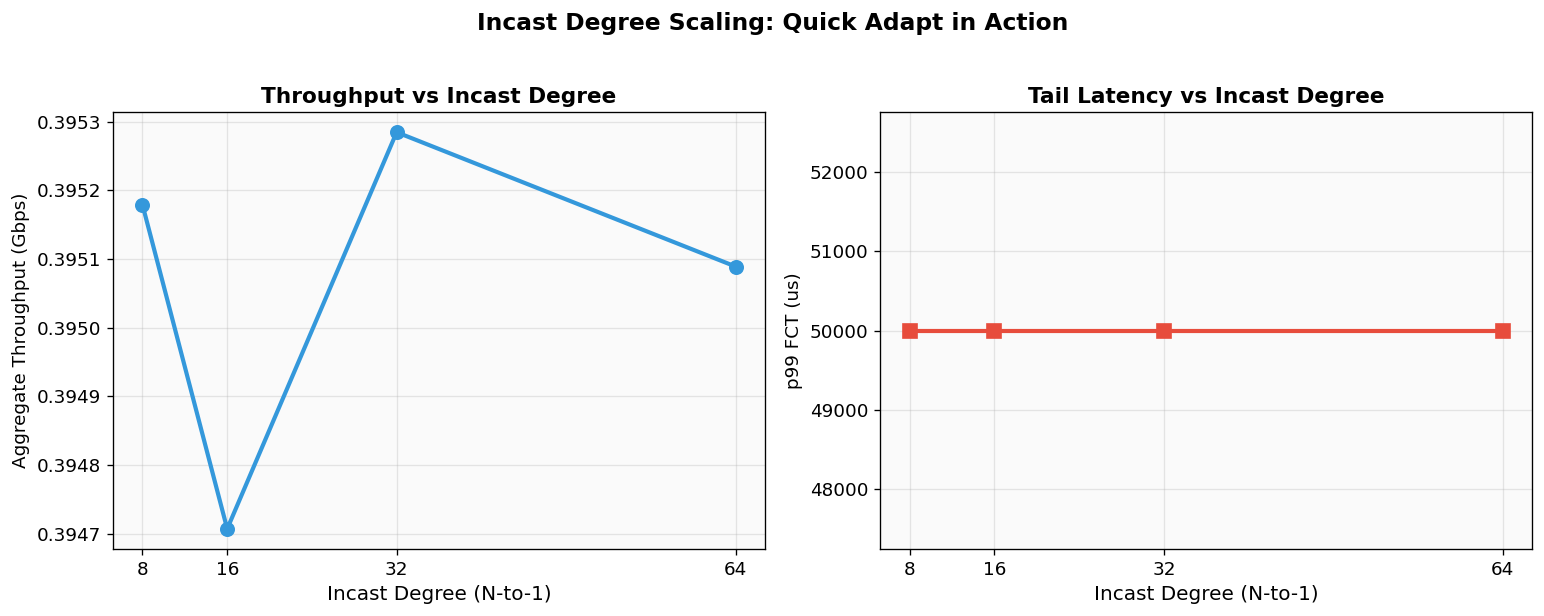

Saved: figures/sim_incast_degree.png


In [29]:
# ── Simulation Figure: Incast Degree Sweep ───────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

degrees = [8, 16, 32, 64]
agg_tputs, tail_fcts = [], []

for deg in degrees:
    csv_path = RESULTS / "incast_degree" / f"incast_{deg}to1.csv"
    if not csv_path.exists():
        agg_tputs.append(np.nan); tail_fcts.append(np.nan)
        continue
    df = pd.read_csv(csv_path)
    active = df[df['bytes_received'] > 0]
    agg_tputs.append(active['throughput_gbps'].sum())
    fcts = active[active['fct_us'] > 0]['fct_us']
    tail_fcts.append(fcts.quantile(0.99) if len(fcts) > 0 else 0)

ax1.plot(degrees, agg_tputs, 'o-', color='#3498db', lw=2.5, markersize=8)
ax1.set_xlabel('Incast Degree (N-to-1)', fontsize=12)
ax1.set_ylabel('Aggregate Throughput (Gbps)', fontsize=11)
ax1.set_title('Throughput vs Incast Degree', fontsize=13, fontweight='bold')
ax1.set_xticks(degrees)

ax2.plot(degrees, tail_fcts, 's-', color='#e74c3c', lw=2.5, markersize=8)
ax2.set_xlabel('Incast Degree (N-to-1)', fontsize=12)
ax2.set_ylabel('p99 FCT (us)', fontsize=11)
ax2.set_title('Tail Latency vs Incast Degree', fontsize=13, fontweight='bold')
ax2.set_xticks(degrees)

fig.suptitle('Incast Degree Scaling: Quick Adapt in Action',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES / 'sim_incast_degree.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: figures/sim_incast_degree.png")

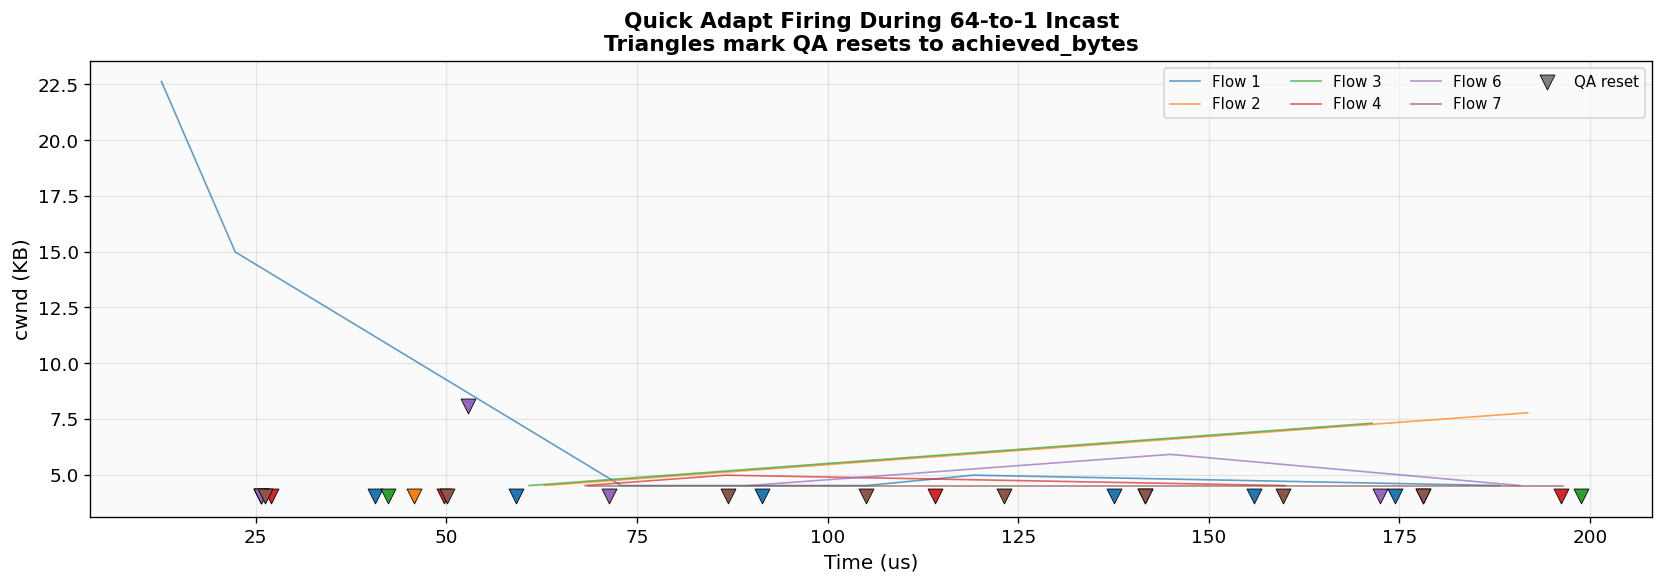

Saved: figures/sim_qa_firing.png


In [30]:
# ── Simulation Figure: QA Firing Time-Series (Phase 2) ───────────────────────
trace_qa_path = RESULTS / "trace_qa" / "qa_64to1_trace.csv"

if trace_qa_path.exists():
    tdf_qa = pd.read_csv(trace_qa_path)
    fig, ax = plt.subplots(figsize=(14, 5))

    # Show cwnd over time for a few flows, highlighting QA events
    regular_qa = tdf_qa[tdf_qa['quadrant'] != 5]
    qa_events = tdf_qa[tdf_qa['quadrant'] == 5]

    flow_ids_qa = sorted(regular_qa['flow_id'].unique())[:6]
    cmap_qa = plt.cm.tab10

    for i, fid in enumerate(flow_ids_qa):
        fdata = regular_qa[regular_qa['flow_id'] == fid]
        ax.plot(fdata['time_us'], fdata['cwnd'] / 1024,
                color=cmap_qa(i), lw=1, alpha=0.7, label=f'Flow {fid}')

        # Mark QA events for this flow
        qa_flow = qa_events[qa_events['flow_id'] == fid]
        if len(qa_flow) > 0:
            ax.scatter(qa_flow['time_us'], qa_flow['cwnd'] / 1024,
                       color=cmap_qa(i), marker='v', s=80, zorder=5,
                       edgecolors='black', linewidths=0.5)

    # Add one QA marker to legend
    ax.scatter([], [], marker='v', s=80, color='gray', edgecolors='black',
               linewidths=0.5, label='QA reset')

    ax.set_xlabel('Time (us)', fontsize=12)
    ax.set_ylabel('cwnd (KB)', fontsize=12)
    ax.set_title('Quick Adapt Firing During 64-to-1 Incast\n'
                 'Triangles mark QA resets to achieved_bytes',
                 fontsize=13, fontweight='bold')
    ax.legend(fontsize=9, ncol=4, loc='upper right')
    plt.tight_layout()
    plt.savefig(FIGURES / 'sim_qa_firing.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: figures/sim_qa_firing.png")
else:
    print(f"Trace data not found at {trace_qa_path}")
    print("Run: python3 run_nscc_experiments.py -e trace_qa")

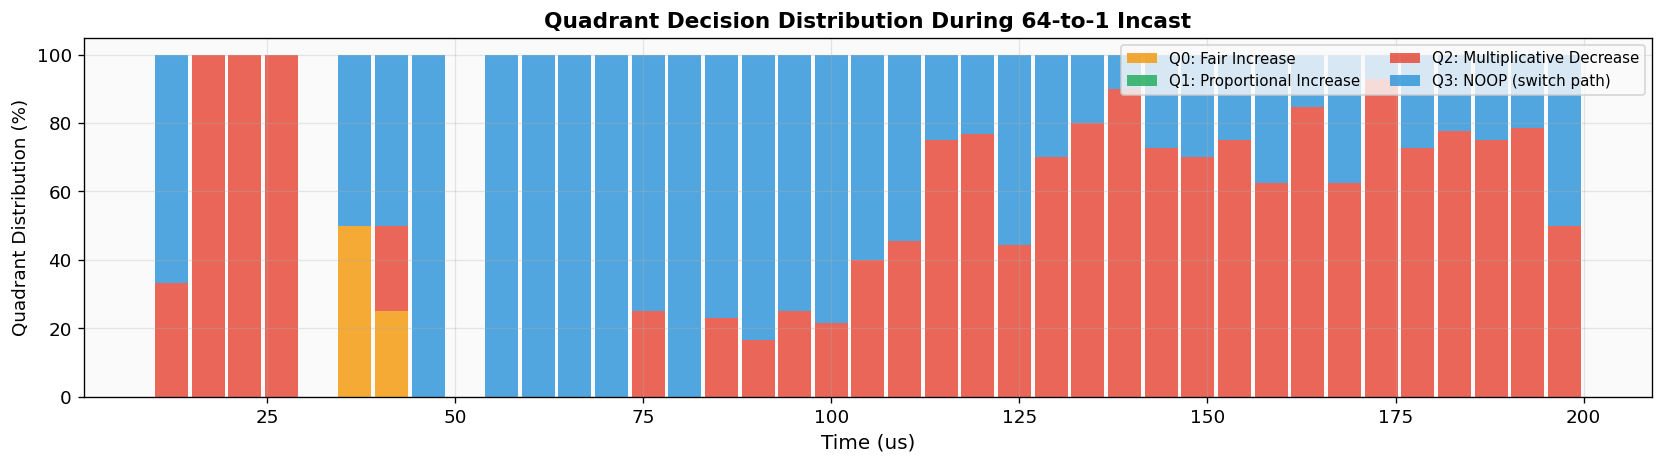

Saved: figures/sim_quadrant_histogram.png


In [31]:
# ── Simulation Figure: Quadrant Histogram Over Time (Phase 2) ────────────────
# Uses same trace data as QA firing experiment
if trace_qa_path.exists():
    tdf_qh = pd.read_csv(trace_qa_path)
    regular_qh = tdf_qh[tdf_qh['quadrant'] != 5]

    fig, ax = plt.subplots(figsize=(14, 4))

    if len(regular_qh) > 0:
        time_bins = np.linspace(regular_qh['time_us'].min(),
                                regular_qh['time_us'].max(), 40)
        q_counts_h = {q: [] for q in range(4)}
        bin_centers_h = []

        for j in range(len(time_bins) - 1):
            mask = ((regular_qh['time_us'] >= time_bins[j]) &
                    (regular_qh['time_us'] < time_bins[j+1]))
            chunk = regular_qh[mask]
            total = max(len(chunk), 1)
            bin_centers_h.append((time_bins[j] + time_bins[j+1]) / 2)
            for q in range(4):
                q_counts_h[q].append(len(chunk[chunk['quadrant'] == q]) / total * 100)

        q_labels_h = ['Q0: Fair Increase', 'Q1: Proportional Increase',
                      'Q2: Multiplicative Decrease', 'Q3: NOOP (switch path)']
        q_colors_h = ['#f39c12', '#27ae60', '#e74c3c', '#3498db']
        bottom_h = np.zeros(len(bin_centers_h))

        for q in range(4):
            ax.bar(bin_centers_h, q_counts_h[q], bottom=bottom_h,
                   width=(time_bins[1]-time_bins[0])*0.9,
                   color=q_colors_h[q], alpha=0.85, label=q_labels_h[q])
            bottom_h += np.array(q_counts_h[q])

        ax.set_xlabel('Time (us)', fontsize=12)
        ax.set_ylabel('Quadrant Distribution (%)', fontsize=11)
        ax.set_title('Quadrant Decision Distribution During 64-to-1 Incast',
                     fontsize=13, fontweight='bold')
        ax.legend(fontsize=9, ncol=2, loc='upper right')
        ax.set_ylim(0, 105)

    plt.tight_layout()
    plt.savefig(FIGURES / 'sim_quadrant_histogram.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: figures/sim_quadrant_histogram.png")
else:
    print("Trace data not available - run trace_qa experiment first")

---
## 6. Packet Spraying & Load Balancing

NSCC operates natively with per-packet spraying. The multipath engine (`uec_mp.h`)
selects an entropy value for each packet determining its physical path.

This is *the other half* of the NOOP quadrant — CC doesn't change the window,
but the multipath engine **steers traffic away from hot paths**.

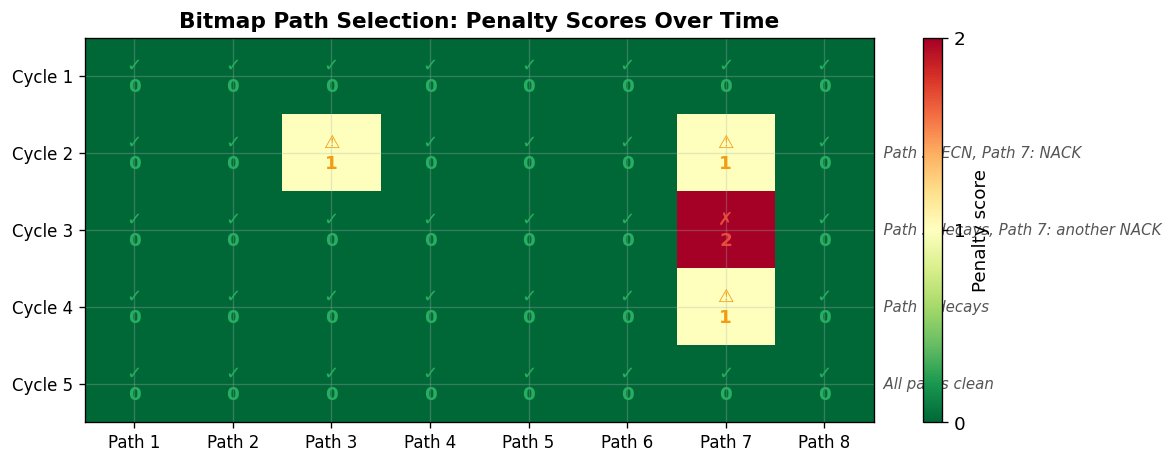

In [32]:
# ── Figure 9: Bitmap path selection over cycles ──────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4))

n_paths = 8
n_cycles = 5
# Score matrix: rows=cycles, cols=paths
scores = np.zeros((n_cycles, n_paths))
# Cycle 0: all clean
# Cycle 1: path 3 gets ECN, path 7 gets NACK
scores[1, 2] = 1; scores[1, 6] = 1
# Cycle 2: path 3 decays, path 7 stays
scores[2, 6] = 2
# Cycle 3: path 7 decays
scores[3, 6] = 1
# Cycle 4: all clean again
scores[4, :] = 0

cmap = plt.cm.RdYlGn_r
im = ax.imshow(scores, cmap=cmap, aspect='auto', vmin=0, vmax=2)

# Labels
for i in range(n_cycles):
    for j in range(n_paths):
        val = int(scores[i, j])
        status = ['✓', '⚠', '✗'][val]
        color = ['#27ae60', '#f39c12', '#e74c3c'][val]
        ax.text(j, i, f'{status}\n{val}', ha='center', va='center',
                fontsize=11, fontweight='bold', color=color)

ax.set_xticks(range(n_paths))
ax.set_xticklabels([f'Path {i+1}' for i in range(n_paths)], fontsize=10)
ax.set_yticks(range(n_cycles))
ax.set_yticklabels([f'Cycle {i+1}' for i in range(n_cycles)], fontsize=10)
ax.set_title('Bitmap Path Selection: Penalty Scores Over Time', fontsize=13, fontweight='bold')

# Events annotations
events = {1: 'Path 3: ECN, Path 7: NACK',
          2: 'Path 3 decays, Path 7: another NACK',
          3: 'Path 7 decays',
          4: 'All paths clean'}
for cycle, event in events.items():
    ax.text(n_paths - 0.5, cycle, f'  {event}', va='center', fontsize=9,
            color='#555', style='italic')

plt.colorbar(im, ax=ax, label='Penalty score', ticks=[0, 1, 2])
plt.tight_layout()
plt.show()

### Four Spraying Strategies

| Strategy | Mechanism | Best for |
|----------|-----------|----------|
| **Oblivious** | Round-robin with random XOR | Symmetric paths |
| **Bitmap** | Penalty scores; skip penalized paths | General use |
| **REPS** | Recycle good paths from circular buffer | Trimming-aware |
| **Mixed** | Hybrid: Bitmap + REPS | Complex topologies |

### Feedback loop (`uec.cpp:1038`)
```cpp
_mp->processEv(pkt.ev(), pkt.ecn_echo() ? PATH_ECN : PATH_GOOD);
```
CC adjusts the **window**. Multipath adjusts the **paths**. Together they close the control loop.

---
## 7. Scaling — One Algorithm, Every Network Speed

NSCC was designed for a 100 Gbps reference network. But the same algorithm must work at 400G,
800G, and beyond. What happens if we don't scale?

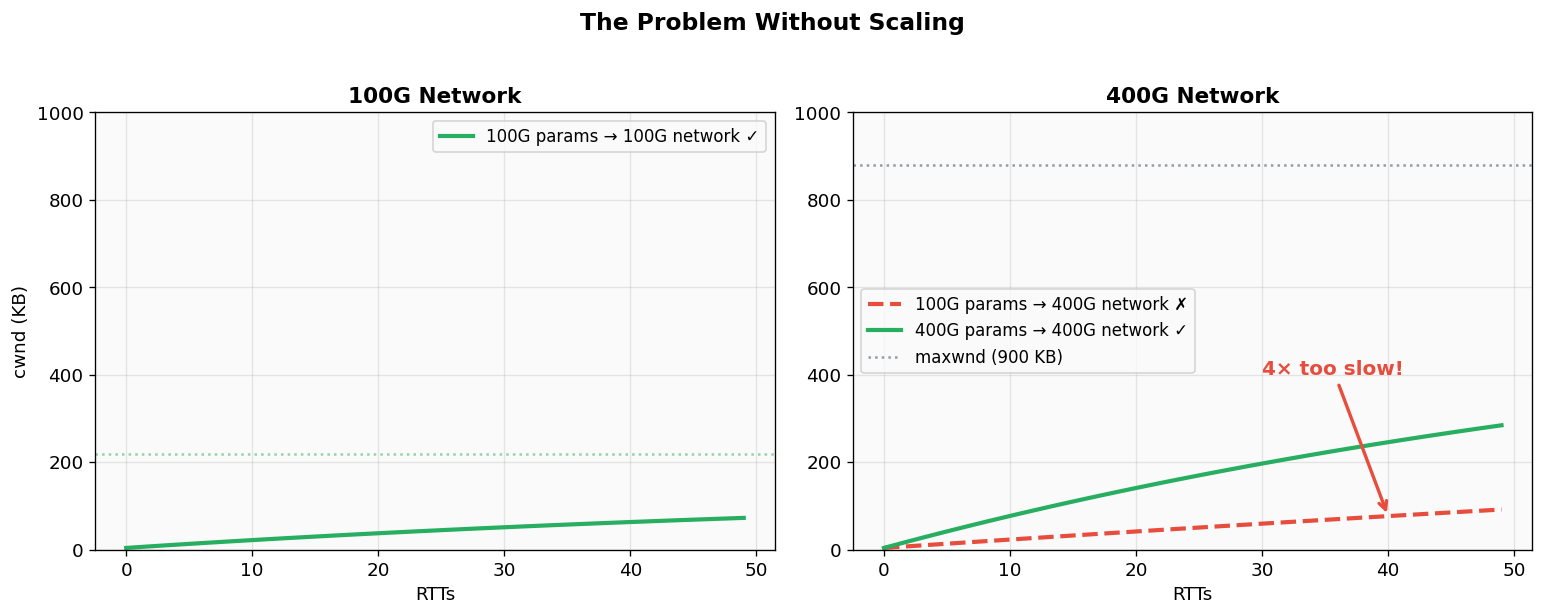

In [33]:
# ── Figure 10: What goes wrong without scaling ───────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Simulate ramp-up: time to fill the pipe
n_rtts = 50
# With 100G params on 100G network
cwnd_100_on_100 = np.zeros(n_rtts)
cwnd_100_on_100[0] = MSS
bdp_100 = REF_BDP
for i in range(1, n_rtts):
    headroom = max(0, 1 - cwnd_100_on_100[i-1] / bdp_100)
    cwnd_100_on_100[i] = cwnd_100_on_100[i-1] + 2000 * headroom
    cwnd_100_on_100[i] = min(cwnd_100_on_100[i], 1.5 * bdp_100)

# 100G params on 400G network (WRONG — no scaling)
cwnd_100_on_400 = np.zeros(n_rtts)
cwnd_100_on_400[0] = MSS
bdp_400 = 4 * REF_BDP
for i in range(1, n_rtts):
    headroom = max(0, 1 - cwnd_100_on_400[i-1] / bdp_400)
    cwnd_100_on_400[i] = cwnd_100_on_400[i-1] + 2000 * headroom  # same increment!
    cwnd_100_on_400[i] = min(cwnd_100_on_400[i], 1.5 * bdp_400)

# 400G params on 400G network (CORRECT — scaled)
cwnd_400_on_400 = np.zeros(n_rtts)
cwnd_400_on_400[0] = MSS
for i in range(1, n_rtts):
    headroom = max(0, 1 - cwnd_400_on_400[i-1] / bdp_400)
    cwnd_400_on_400[i] = cwnd_400_on_400[i-1] + 8000 * headroom  # 4× increment
    cwnd_400_on_400[i] = min(cwnd_400_on_400[i], 1.5 * bdp_400)

rtts = np.arange(n_rtts)
ax1.plot(rtts, cwnd_100_on_100/1024, color='#27ae60', lw=2.5, label='100G params → 100G network ✓')
ax1.axhline(1.5*bdp_100/1024, color='#27ae60', ls=':', alpha=0.5)
ax1.set_title('100G Network', fontsize=13, fontweight='bold')
ax1.set_xlabel('RTTs'); ax1.set_ylabel('cwnd (KB)')
ax1.legend(fontsize=10); ax1.set_ylim(0, 1000)

ax2.plot(rtts, cwnd_100_on_400/1024, color='#e74c3c', lw=2.5, ls='--',
         label='100G params → 400G network ✗')
ax2.plot(rtts, cwnd_400_on_400/1024, color='#27ae60', lw=2.5,
         label='400G params → 400G network ✓')
ax2.axhline(1.5*bdp_400/1024, color='#2c3e50', ls=':', alpha=0.5, label='maxwnd (900 KB)')
ax2.annotate('4× too slow!', xy=(40, cwnd_100_on_400[40]/1024), xytext=(30, 400),
             fontsize=12, fontweight='bold', color='#e74c3c',
             arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=2))
ax2.set_title('400G Network', fontsize=13, fontweight='bold')
ax2.set_xlabel('RTTs')
ax2.legend(fontsize=10); ax2.set_ylim(0, 1000)

fig.suptitle('The Problem Without Scaling', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

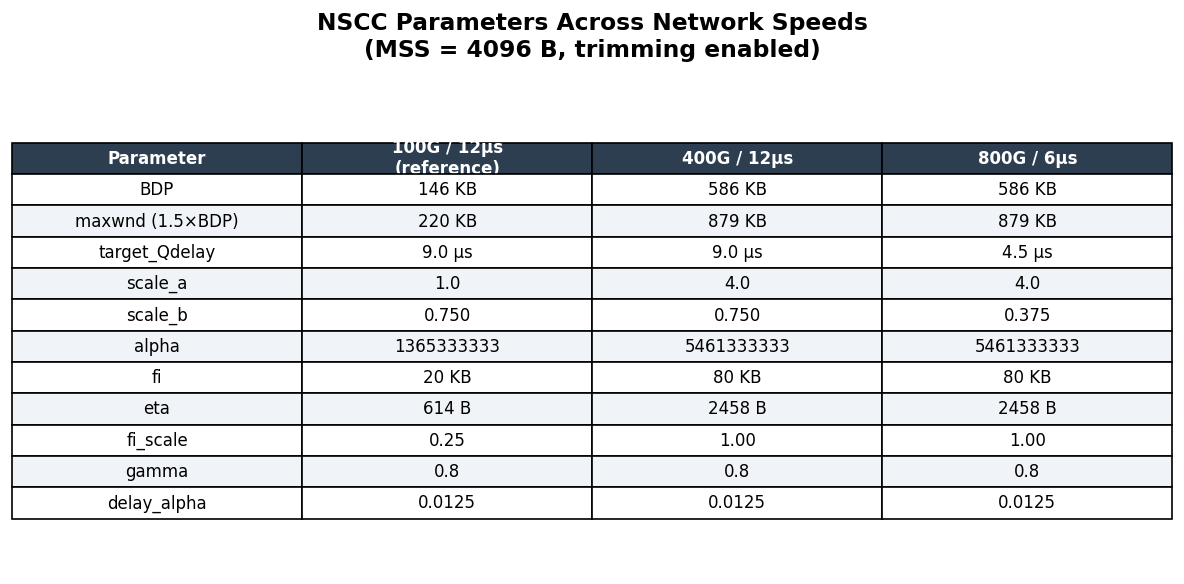

In [34]:
# ── Figure 11: Scaling parameter table ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')

col_labels = ['Parameter', '100G / 12µs\n(reference)', '400G / 12µs', '800G / 6µs']
table_data = []

for label, key, fmt in [
    ('BDP',              'bdp',       lambda v: f'{v/1024:.0f} KB'),
    ('maxwnd (1.5×BDP)', 'maxwnd',    lambda v: f'{v/1024:.0f} KB'),
    ('target_Qdelay',    'target_us', lambda v: f'{v:.1f} µs'),
    ('scale_a',          'sa',        lambda v: f'{v:.1f}'),
    ('scale_b',          'sb',        lambda v: f'{v:.3f}'),
    ('alpha',            'alpha',     lambda v: f'{v:.0f}'),
    ('fi',               'fi',        lambda v: f'{v/1024:.0f} KB'),
    ('eta',              'eta',       lambda v: f'{v:.0f} B'),
    ('fi_scale',         'fi_scale',  lambda v: f'{v:.2f}'),
    ('gamma',            'gamma',     lambda v: f'{v}'),
    ('delay_alpha',      'delay_alpha', lambda v: f'{v}'),
]:
    row = [label]
    for p in [P100, P400, P800]:
        row.append(fmt(p[key]))
    table_data.append(row)

table = ax.table(cellText=table_data, colLabels=col_labels,
                 loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Style header
for j in range(len(col_labels)):
    table[0, j].set_facecolor('#2c3e50')
    table[0, j].set_text_props(color='white', fontweight='bold')

# Alternate row colors
for i in range(1, len(table_data) + 1):
    color = '#f0f4f8' if i % 2 == 0 else 'white'
    for j in range(len(col_labels)):
        table[i, j].set_facecolor(color)

ax.set_title('NSCC Parameters Across Network Speeds\n'
             '(MSS = 4096 B, trimming enabled)',
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### Scaling Factors (`uec.cpp:121-122`)

$$\text{scale\_a} = \frac{\text{network\_BDP}}{\text{reference\_BDP}} \qquad
  \text{scale\_b} = \frac{\text{target\_Qdelay}}{\text{reference\_RTT}}$$

| Parameter | Formula | Scales with |
|-----------|---------|-------------|
| `alpha`   | $4 \times \text{MSS} \times a \times b \;/\; \text{target}$ | Capacity + delay |
| `fi`      | $5 \times \text{MSS} \times a$ | Capacity only |
| `eta`     | $0.15 \times \text{MSS} \times a$ | Capacity only |
| `fi_scale`| $0.25 \times a$ | Capacity only |

**Key invariant:** at any network speed, the algorithm takes roughly the same number of RTTs
to fill the pipe and converge to fairness.

### Per-Flow vs Global Parameters

- **Global (static):** alpha, fi, eta, gamma, target, delay_alpha, min_cwnd — set once via `initNsccParams()` (`uec.cpp:86-159`)
- **Per-flow (instance):** base_rtt, bdp, maxwnd, cwnd, avg_delay — set via `initNscc()` (`uec.cpp:161-184`)

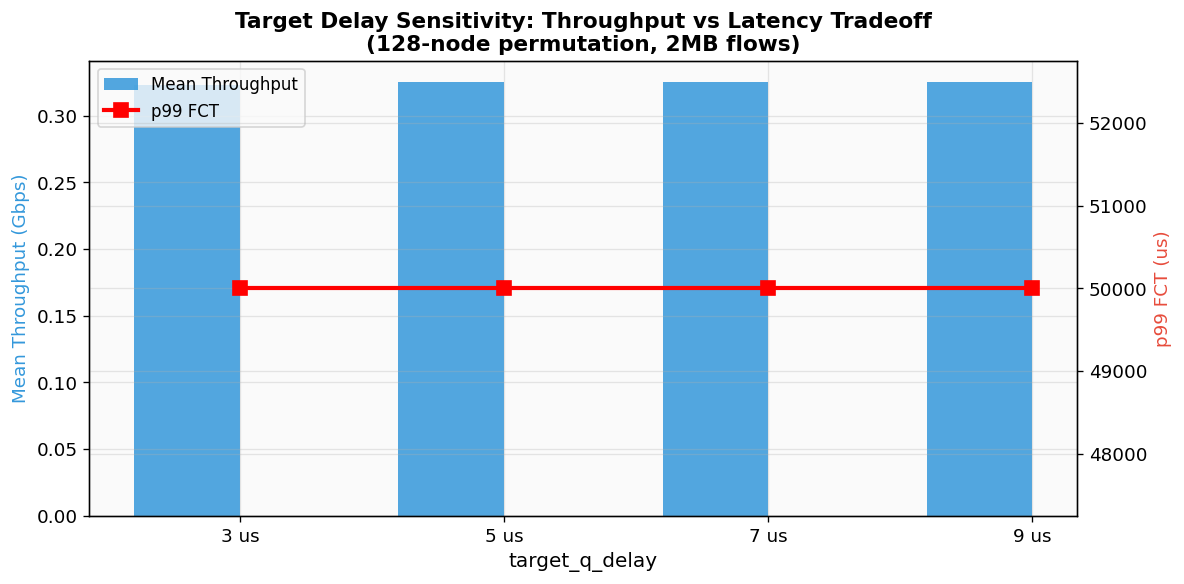

Saved: figures/sim_target_delay.png


In [35]:
# ── Simulation Figure: Target Delay Sensitivity ──────────────────────────────
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2_td = ax1.twinx()

delays_us = [3, 5, 7, 9]
mean_tputs_td, p99_fcts_td = [], []

for d in delays_us:
    csv_path = RESULTS / "target_delay" / f"target_delay_{d}us.csv"
    if not csv_path.exists():
        mean_tputs_td.append(np.nan); p99_fcts_td.append(np.nan)
        continue
    df = pd.read_csv(csv_path)
    active = df[df['bytes_received'] > 0]
    mean_tputs_td.append(active['throughput_gbps'].mean() if len(active) > 0 else 0)
    fcts = active[active['fct_us'] > 0]['fct_us']
    p99_fcts_td.append(fcts.quantile(0.99) if len(fcts) > 0 else 0)

x_td = np.arange(len(delays_us))
ax1.bar(x_td - 0.2, mean_tputs_td, 0.4, color='#3498db', alpha=0.85, label='Mean Throughput')
ax1.set_xticks(x_td)
ax1.set_xticklabels([f'{d} us' for d in delays_us], fontsize=11)
ax1.set_xlabel('target_q_delay', fontsize=12)
ax1.set_ylabel('Mean Throughput (Gbps)', fontsize=11, color='#3498db')

ax2_td.plot(x_td, p99_fcts_td, 'rs-', lw=2.5, markersize=8, label='p99 FCT')
ax2_td.set_ylabel('p99 FCT (us)', fontsize=11, color='#e74c3c')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2_td.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10, loc='upper left')

ax1.set_title('Target Delay Sensitivity: Throughput vs Latency Tradeoff\n'
              '(128-node permutation, 2MB flows)',
              fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES / 'sim_target_delay.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: figures/sim_target_delay.png")

---
## 8. SLEEK Loss Recovery

### Why TCP's 3-DupACK Fails with Spraying

TCP detects loss when 3 ACKs arrive for the same sequence number. This works on a single path
where packets arrive in order. With spraying, **reordering is the norm**:

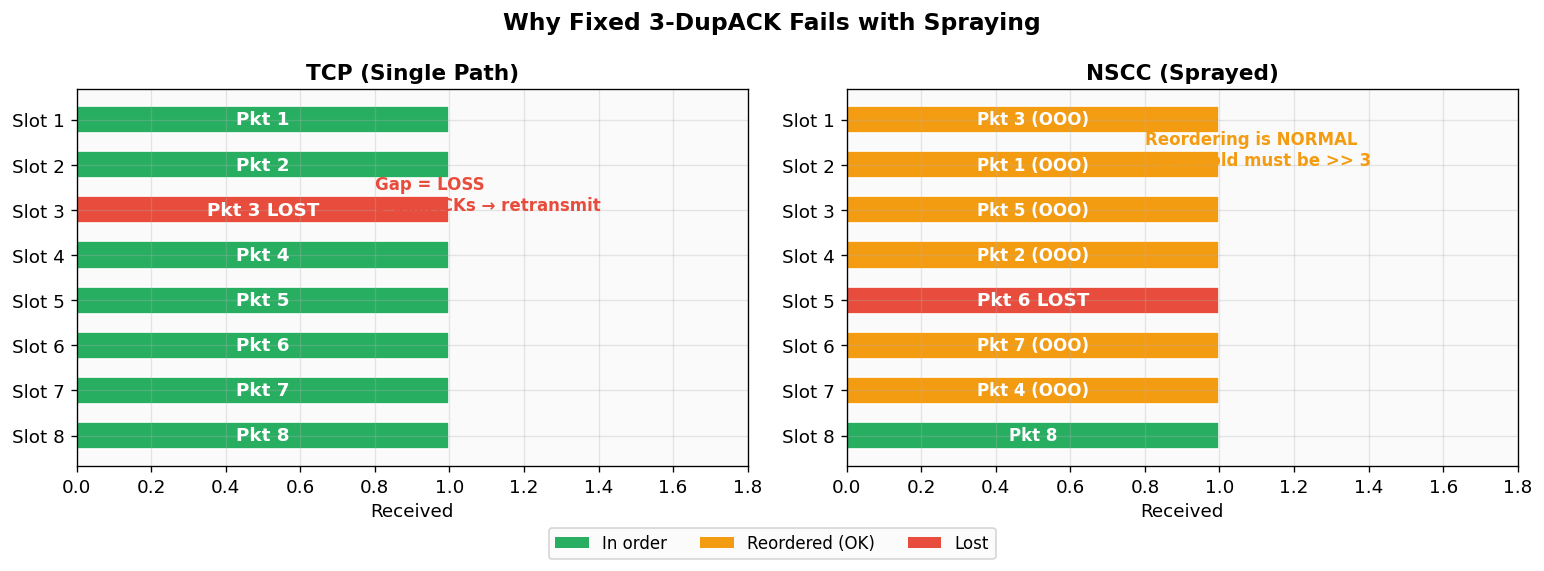

In [36]:
# ── Figure 12: TCP vs Sprayed reordering ─────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5))

# TCP: single path — ordered delivery with gap at pkt 3
sent =     [1, 2, 3, 4, 5, 6, 7, 8]
tcp_recv = [1, 2, None, 4, 5, 6, 7, 8]  # packet 3 lost

x = np.arange(len(sent))
ax1.barh(x, [1]*len(sent), color=['#27ae60' if r else '#e74c3c' for r in tcp_recv],
         edgecolor='white', height=0.6)
for i, (s, r) in enumerate(zip(sent, tcp_recv)):
    if r:
        ax1.text(0.5, i, f'Pkt {r}', ha='center', va='center', fontsize=11,
                 fontweight='bold', color='white')
    else:
        ax1.text(0.5, i, f'Pkt {s} LOST', ha='center', va='center', fontsize=11,
                 fontweight='bold', color='white')
ax1.set_yticks(x); ax1.set_yticklabels([f'Slot {i+1}' for i in x])
ax1.set_title('TCP (Single Path)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Received')
ax1.annotate('Gap = LOSS\n3 dupACKs → retransmit',
             xy=(0.8, 2), fontsize=10, color='#e74c3c', fontweight='bold')
ax1.set_xlim(0, 1.8); ax1.invert_yaxis()

# NSCC: sprayed — packets arrive in random order
nscc_recv = [3, 1, 5, 2, None, 7, 4, 8]  # reordered + pkt 6 lost
ax2.barh(x, [1]*len(sent), height=0.6, edgecolor='white',
         color=['#f39c12' if r and r != i+1 else ('#27ae60' if r else '#e74c3c')
                for i, r in enumerate(nscc_recv)])
for i, r in enumerate(nscc_recv):
    if r:
        ooo = ' (OOO)' if r != i + 1 else ''
        ax2.text(0.5, i, f'Pkt {r}{ooo}', ha='center', va='center', fontsize=10,
                 fontweight='bold', color='white')
    else:
        ax2.text(0.5, i, f'Pkt 6 LOST', ha='center', va='center', fontsize=11,
                 fontweight='bold', color='white')
ax2.set_yticks(x); ax2.set_yticklabels([f'Slot {i+1}' for i in x])
ax2.set_title('NSCC (Sprayed)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Received')
ax2.annotate('Reordering is NORMAL\nThreshold must be >> 3',
             xy=(0.8, 1), fontsize=10, color='#f39c12', fontweight='bold')
ax2.set_xlim(0, 1.8); ax2.invert_yaxis()

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#27ae60', label='In order'),
                   Patch(facecolor='#f39c12', label='Reordered (OK)'),
                   Patch(facecolor='#e74c3c', label='Lost')]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=10,
           bbox_to_anchor=(0.5, -0.05))

fig.suptitle('Why Fixed 3-DupACK Fails with Spraying', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### SLEEK's Approach (`uec.cpp:1433-1497`)

SLEEK uses a **cwnd-scaled threshold** instead of a fixed count:

$$\text{threshold} = \min(1.5 \times \text{cwnd},\; \text{maxwnd})$$

With a 600 KB window and 4 KB packets, that's **~225 out-of-order packets** before triggering
loss recovery (vs TCP's fixed 3). In a spraying network with 16 paths, any packet might arrive
15 positions late — this is expected, not exceptional.

### Entry and exit:
```cpp
// Enter (uec.cpp:1460-1466)
if (!_loss_recovery_mode && _rtx_queue.empty()) {
    _loss_recovery_mode = true;
    _recovery_seqno = _highest_sent;
}

// Exit (uec.cpp:1450-1455)
if (cum_ack >= _recovery_seqno && _loss_recovery_mode)
    _loss_recovery_mode = false;
```

SLEEK also uses **explicit probes** (`uec.cpp:1066-1092`): if a probe ACK returns with low delay,
it indicates the "missing" packets were truly lost (not just delayed).

---
## 9. Comparison: NSCC vs TCP Cubic vs DCQCN

| Property | NSCC | TCP Cubic | DCQCN |
|----------|------|-----------|-------|
| **CC Type** | Window-based | Window-based | Rate-based |
| **Primary Signal** | Delay + ECN | Loss + ECN | ECN via CNP |
| **Increase** | Proportional to (target − delay) | Cubic function of time | Timer + byte-counter |
| **Decrease** | $\gamma(d{-}t)/d$, max 50% | Fixed β=0.7 | $R_C(1{-}\alpha/2)$ |
| **Multi-path** | Native (per-packet spray) | Single-path | Single-path |
| **Fairness** | Jain's FI ≈ 1.000 | FI ≈ 0.976-0.997 | Adaptive (α-driven) |

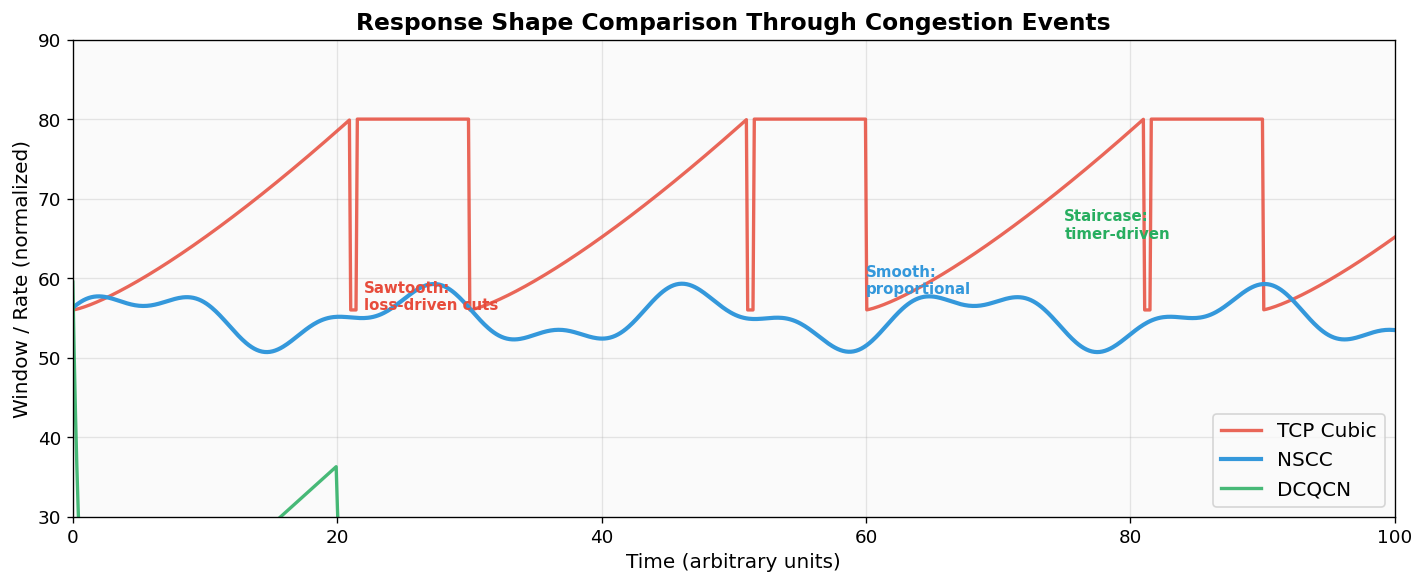

In [37]:
# ── Figure 13: Response shape comparison ──────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 5))

t = np.linspace(0, 100, 1000)

# TCP Cubic: sawtooth with cubic recovery
def cubic_cwnd(t, period=25, wmax=80, beta=0.7):
    phase = t % period
    k = (wmax * (1 - beta)) ** (1/3)
    return np.clip(wmax * (1 - beta) * ((phase/period * k * 3 - k) ** 3) + wmax * beta + 15,
                   wmax * beta, wmax)

tcp = np.zeros_like(t)
wmax = 80
for i, ti in enumerate(t):
    period = 30
    phase = ti % period
    if phase < period * 0.7:
        # Cubic recovery
        tcp[i] = wmax * 0.7 + (wmax * 0.3) * (phase / (period * 0.7)) ** 1.3
    else:
        # Sudden drop
        tcp[i] = wmax

# Add sharp drops
for drop_t in [21, 51, 81]:
    mask = (t >= drop_t) & (t < drop_t + 0.5)
    tcp[mask] = wmax * 0.7

# NSCC: smooth oscillation around target
nscc = 55 + 3 * np.sin(t * 0.3) + 1.5 * np.sin(t * 0.7 + 1)

# DCQCN: staircase
dcqcn = np.zeros_like(t)
level = 70
for i, ti in enumerate(t):
    phase = ti % 20
    if phase < 1:  # CNP drop
        level = level * 0.85
    elif phase > 5:  # timer recovery
        level = min(level + 0.15, 70)
    dcqcn[i] = level

ax.plot(t, tcp, color='#e74c3c', lw=2, label='TCP Cubic', alpha=0.85)
ax.plot(t, nscc, color='#3498db', lw=2.5, label='NSCC')
ax.plot(t, dcqcn, color='#27ae60', lw=2, label='DCQCN', alpha=0.85)

ax.set_xlabel('Time (arbitrary units)', fontsize=12)
ax.set_ylabel('Window / Rate (normalized)', fontsize=12)
ax.set_title('Response Shape Comparison Through Congestion Events',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc='lower right')
ax.set_xlim(0, 100); ax.set_ylim(30, 90)

# Annotations
ax.annotate('Sawtooth:\nloss-driven cuts', xy=(22, 56), fontsize=9,
            color='#e74c3c', fontweight='bold')
ax.annotate('Smooth:\nproportional', xy=(60, 58), fontsize=9,
            color='#3498db', fontweight='bold')
ax.annotate('Staircase:\ntimer-driven', xy=(75, 65), fontsize=9,
            color='#27ae60', fontweight='bold')

plt.tight_layout()
plt.show()

### Design Philosophies

**NSCC:** *"Respond proportionally to what the network tells you, on two dimensions."*
Delay provides magnitude, ECN provides per-path classification.
The four-quadrant design means it never overreacts to ambiguous signals.

**TCP Cubic:** *"Probe aggressively, back off on loss."*
The cubic function $W(t) = C(t-K)^3 + W_{\max}$ creates a distinctive convex-then-concave
growth curve. Time-based (not RTT-based), so it's fair across different RTTs. (`tcpcubic.cpp:8`)

**DCQCN:** *"Adjust rate based on ECN feedback via a separate control plane."*
The receiver generates CNP packets. The sender cuts rate by $\alpha/2$ per CNP and recovers
through three timer-driven phases. (`dcqcn.cpp:20-56`)

### Key Assumptions

| NSCC | TCP Cubic | DCQCN |
|------|-----------|-------|
| Multi-path spray | Single path | Single path |
| Shallow buffers | Deep buffers OK | Lossless (PFC) |
| Known base RTT | Loss = signal | ECN + CNP |
| ECN at switches | ECN optional | Hardware rate limiter |

### Response Timing

| | NSCC | TCP Cubic | DCQCN |
|---|---|---|---|
| **Decrease** | Immediate (1× per RTT) | Per loss event | Per CNP (50µs min) |
| **Increase** | Batched (~8 MTUs or 1 RTT) | Per ACK | 55µs timer |

---
### Simulation: NSCC vs TCP Cubic Coexistence

The following cells load real simulation results from `htsim_mixed` runs sweeping `nscc_ratio` from 0% to 100% across three traffic scenarios. Run `python3 run_nscc_experiments.py -e coexistence` to generate the data.

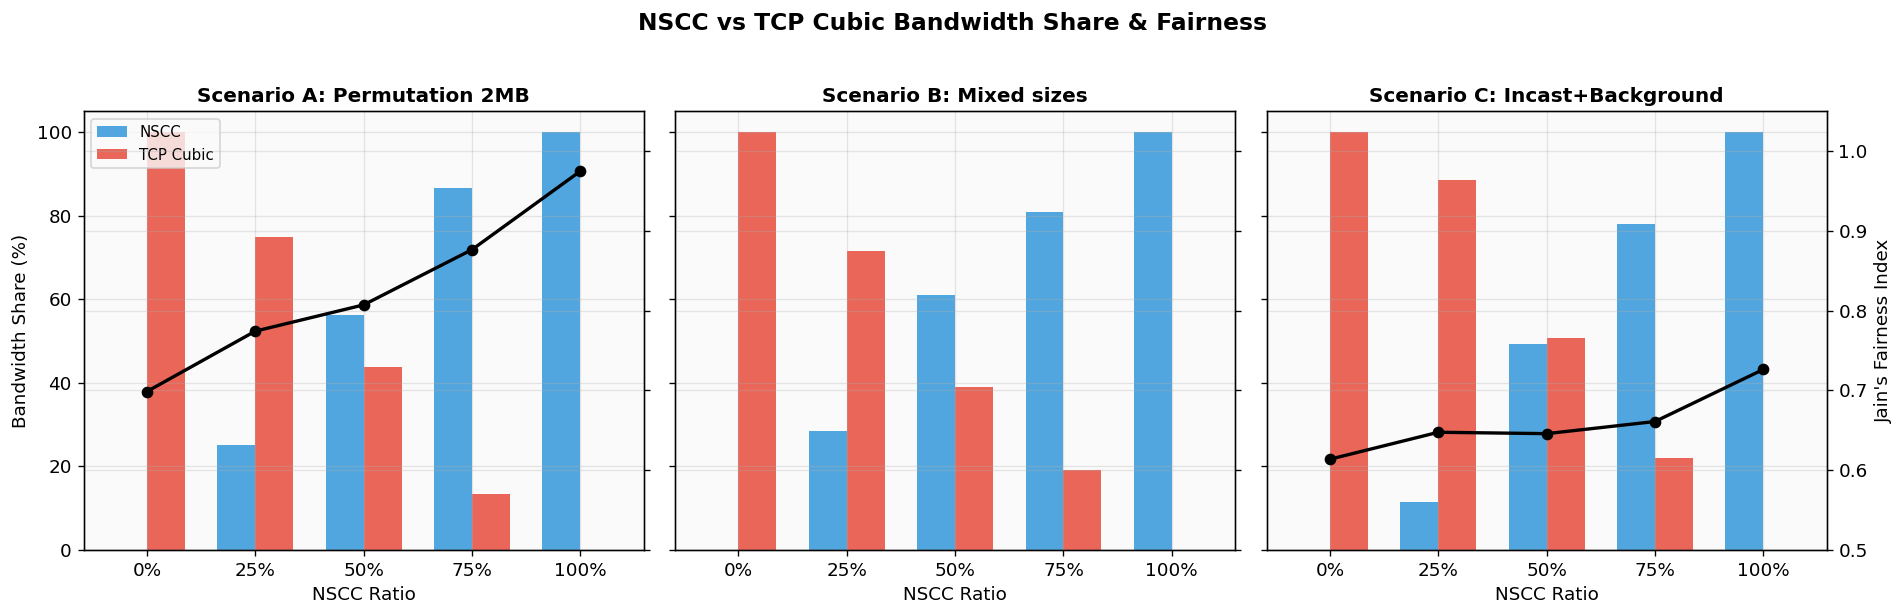

Saved: figures/sim_coexistence.png


In [38]:
# ── Simulation Figure: NSCC vs Cubic Coexistence (3-panel) ───────────────────
import pandas as pd
from pathlib import Path

RESULTS = Path("results/deep_dive")
FIGURES = Path("figures")
FIGURES.mkdir(parents=True, exist_ok=True)

scenarios = {"A": "Permutation 2MB", "B": "Mixed sizes", "C": "Incast+Background"}
ratios = [0, 25, 50, 75, 100]

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for idx, (scen, title) in enumerate(scenarios.items()):
    ax = axes[idx]
    nscc_shares, cubic_shares, jains = [], [], []

    for r in ratios:
        csv_path = RESULTS / "coexistence" / f"coexist_scen{scen}_ratio{r}.csv"
        if not csv_path.exists():
            nscc_shares.append(np.nan); cubic_shares.append(np.nan); jains.append(np.nan)
            continue
        df = pd.read_csv(csv_path)
        nscc_bw = df[df['protocol'] == 'NSCC']['throughput_gbps'].sum()
        cubic_bw = df[df['protocol'] == 'CUBIC']['throughput_gbps'].sum()
        total = nscc_bw + cubic_bw
        nscc_shares.append(nscc_bw / total * 100 if total > 0 else 0)
        cubic_shares.append(cubic_bw / total * 100 if total > 0 else 0)
        # Jain's FI
        tputs = df['throughput_gbps'].values
        tputs = tputs[tputs > 0]
        if len(tputs) > 1:
            jains.append((tputs.sum()**2) / (len(tputs) * (tputs**2).sum()))
        else:
            jains.append(np.nan)

    x = np.arange(len(ratios))
    width = 0.35
    ax.bar(x - width/2, nscc_shares, width, label='NSCC', color='#3498db', alpha=0.85)
    ax.bar(x + width/2, cubic_shares, width, label='TCP Cubic', color='#e74c3c', alpha=0.85)

    # Overlay Jain's FI on secondary axis
    ax2 = ax.twinx()
    ax2.plot(x, jains, 'ko-', lw=2, markersize=6, label="Jain's FI")
    ax2.set_ylim(0.5, 1.05)
    if idx == 2:
        ax2.set_ylabel("Jain's Fairness Index", fontsize=11)
    else:
        ax2.set_yticklabels([])

    ax.set_xticks(x)
    ax.set_xticklabels([f'{r}%' for r in ratios])
    ax.set_xlabel('NSCC Ratio', fontsize=11)
    ax.set_title(f'Scenario {scen}: {title}', fontsize=12, fontweight='bold')
    if idx == 0:
        ax.set_ylabel('Bandwidth Share (%)', fontsize=11)
        ax.legend(loc='upper left', fontsize=9)

fig.suptitle('NSCC vs TCP Cubic Bandwidth Share & Fairness',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES / 'sim_coexistence.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: figures/sim_coexistence.png")

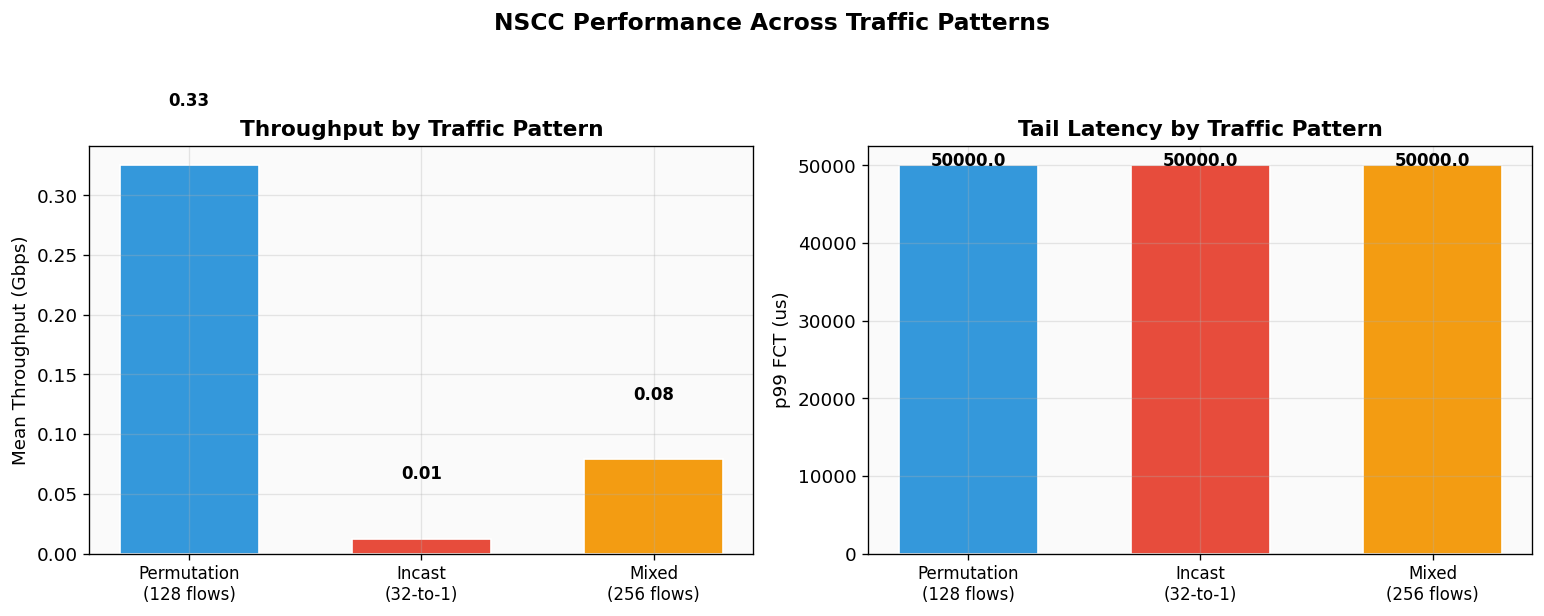

Saved: figures/sim_traffic_pattern.png


In [39]:
# ── Simulation Figure: Traffic Pattern Comparison ────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

patterns = ['permutation', 'incast', 'mixed']
pattern_labels = ['Permutation\n(128 flows)', 'Incast\n(32-to-1)', 'Mixed\n(256 flows)']
colors_pat = ['#3498db', '#e74c3c', '#f39c12']

mean_tputs, p99_fcts, completion_rates = [], [], []

for pat in patterns:
    csv_path = RESULTS / "traffic_pattern" / f"pattern_{pat}.csv"
    if not csv_path.exists():
        mean_tputs.append(0); p99_fcts.append(0); completion_rates.append(0)
        continue
    df = pd.read_csv(csv_path)
    active = df[df['bytes_received'] > 0]
    mean_tputs.append(active['throughput_gbps'].mean() if len(active) > 0 else 0)
    fcts = active[active['fct_us'] > 0]['fct_us']
    p99_fcts.append(fcts.quantile(0.99) if len(fcts) > 0 else 0)
    if len(df[df['size_bytes'] > 0]) > 0:
        completion_rates.append(df['finished'].sum() / len(df[df['size_bytes'] > 0]) * 100)
    else:
        completion_rates.append(0)

x = np.arange(len(patterns))
bars1 = ax1.bar(x, mean_tputs, color=colors_pat, edgecolor='white', width=0.6)
ax1.set_xticks(x); ax1.set_xticklabels(pattern_labels, fontsize=10)
ax1.set_ylabel('Mean Throughput (Gbps)', fontsize=11)
ax1.set_title('Throughput by Traffic Pattern', fontsize=13, fontweight='bold')
for bar, val in zip(bars1, mean_tputs):
    if val > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f'{val:.2f}', ha='center', fontsize=10, fontweight='bold')

bars2 = ax2.bar(x, p99_fcts, color=colors_pat, edgecolor='white', width=0.6)
ax2.set_xticks(x); ax2.set_xticklabels(pattern_labels, fontsize=10)
ax2.set_ylabel('p99 FCT (us)', fontsize=11)
ax2.set_title('Tail Latency by Traffic Pattern', fontsize=13, fontweight='bold')
for bar, val in zip(bars2, p99_fcts):
    if val > 0:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{val:.1f}', ha='center', fontsize=10, fontweight='bold')

fig.suptitle('NSCC Performance Across Traffic Patterns',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES / 'sim_traffic_pattern.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: figures/sim_traffic_pattern.png")

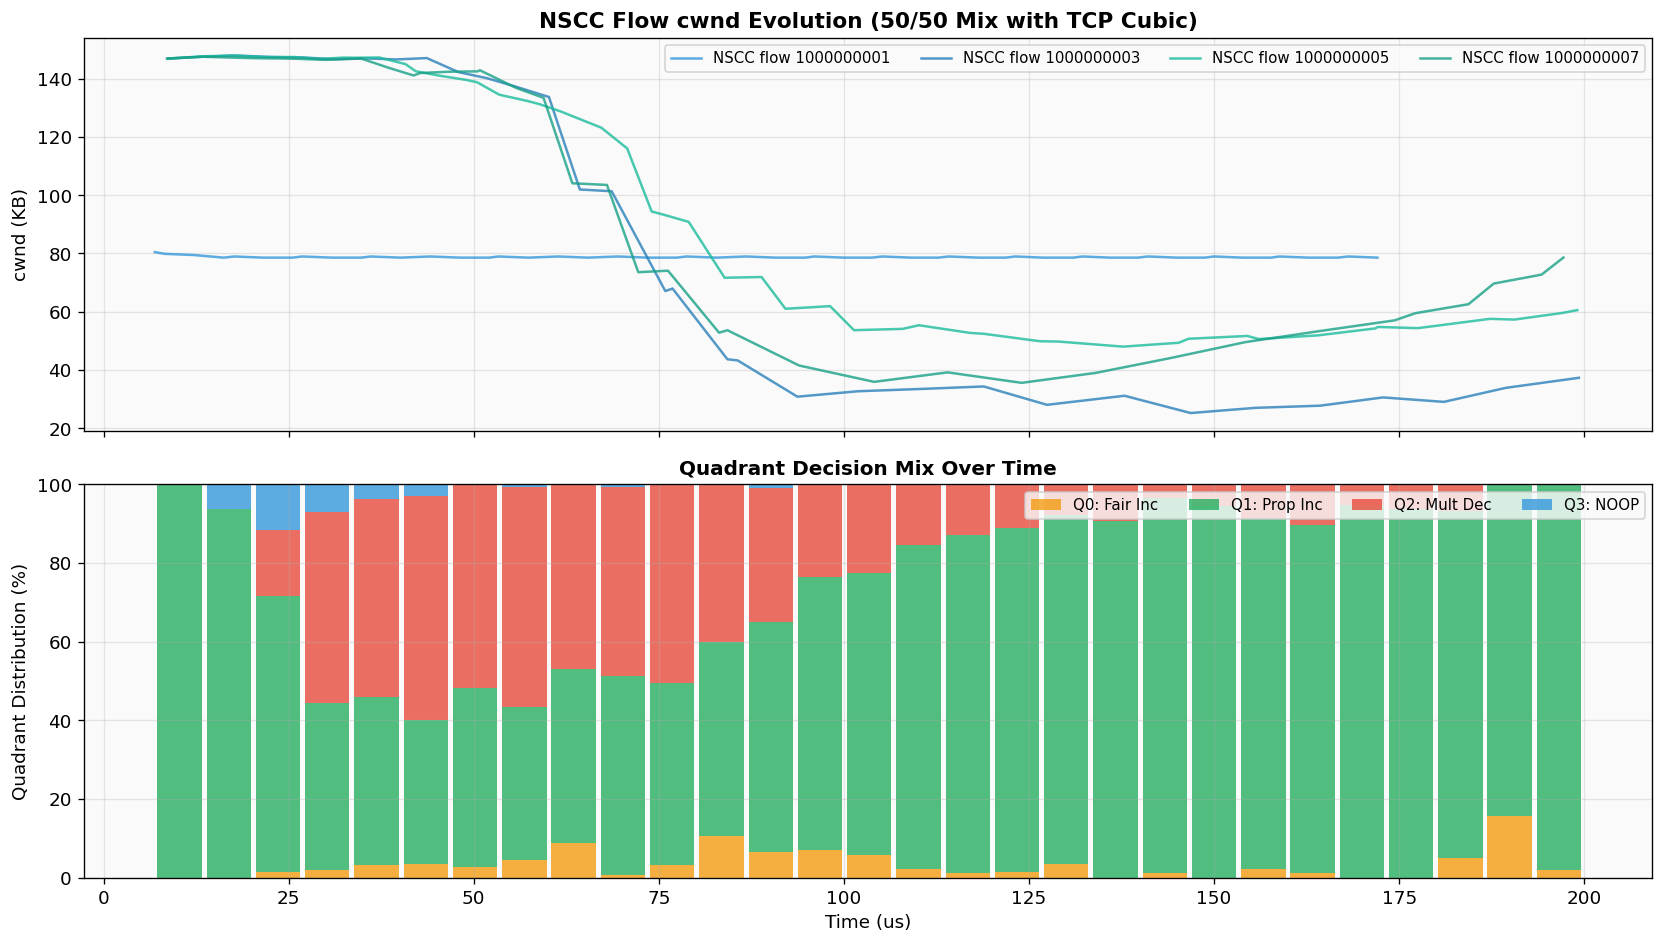

Saved: figures/sim_cwnd_nscc_vs_cubic.png


In [40]:
# ── Simulation Figure: NSCC vs Cubic cwnd Time-Series (Phase 2) ──────────────
trace_path = RESULTS / "trace_coexist" / "coexist_50_50_trace.csv"

if trace_path.exists():
    tdf = pd.read_csv(trace_path)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Pick first 4 NSCC flows (quadrant != 5 to filter QA events for regular samples)
    regular = tdf[tdf['quadrant'] != 5]
    flow_ids = sorted(regular['flow_id'].unique())[:4]
    nscc_colors = ['#3498db', '#2980b9', '#1abc9c', '#16a085']

    for i, fid in enumerate(flow_ids):
        fdata = regular[regular['flow_id'] == fid]
        ax1.plot(fdata['time_us'], fdata['cwnd'] / 1024,
                 color=nscc_colors[i % len(nscc_colors)], lw=1.5, alpha=0.8,
                 label=f'NSCC flow {fid}')

    ax1.set_ylabel('cwnd (KB)', fontsize=11)
    ax1.set_title('NSCC Flow cwnd Evolution (50/50 Mix with TCP Cubic)',
                  fontsize=13, fontweight='bold')
    ax1.legend(fontsize=9, ncol=4, loc='upper right')

    # Show quadrant distribution over time
    if len(regular) > 0:
        time_bins = np.linspace(regular['time_us'].min(), regular['time_us'].max(), 30)
        q_counts = {q: [] for q in range(4)}
        bin_centers = []
        for j in range(len(time_bins) - 1):
            mask = (regular['time_us'] >= time_bins[j]) & (regular['time_us'] < time_bins[j+1])
            chunk = regular[mask]
            total = max(len(chunk), 1)
            bin_centers.append((time_bins[j] + time_bins[j+1]) / 2)
            for q in range(4):
                q_counts[q].append(len(chunk[chunk['quadrant'] == q]) / total * 100)

        q_labels = ['Q0: Fair Inc', 'Q1: Prop Inc', 'Q2: Mult Dec', 'Q3: NOOP']
        q_colors = ['#f39c12', '#27ae60', '#e74c3c', '#3498db']
        bottom = np.zeros(len(bin_centers))
        for q in range(4):
            ax2.bar(bin_centers, q_counts[q], bottom=bottom,
                    width=(time_bins[1]-time_bins[0])*0.9,
                    color=q_colors[q], alpha=0.8, label=q_labels[q])
            bottom += np.array(q_counts[q])

        ax2.set_ylabel('Quadrant Distribution (%)', fontsize=11)
        ax2.set_xlabel('Time (us)', fontsize=11)
        ax2.legend(fontsize=9, ncol=4, loc='upper right')
        ax2.set_title('Quadrant Decision Mix Over Time', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(FIGURES / 'sim_cwnd_nscc_vs_cubic.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: figures/sim_cwnd_nscc_vs_cubic.png")
else:
    print(f"Trace data not found at {trace_path}")
    print("Run: python3 run_nscc_experiments.py -e trace_coexist")

---
## 10. Intuition Summary — What We Discovered

Walking through this notebook, we arrived at each piece of NSCC by asking
*what we need* and *what goes wrong* with simpler approaches:

| # | Problem | → Solution | Key formula |
|---|---------|-----------|-------------|
| 1 | Single-signal CC fails with spraying | Two signals: delay + ECN | Four quadrants |
| 2 | Constant increase overshoots | Proportional to headroom | $\alpha(t - d)$ |
| 3 | Fixed decrease overreacts | Proportional to severity | $\gamma(d-t)/d$, floor 0.5 |
| 4 | Per-ACK updates oscillate | Batched fulfill adjustment | $\Delta w = \Sigma / w$ |
| 5 | Fast filters thrash on noise | Slow EWMA (α=1/80) | ~80 samples to 63% |
| 6 | Iterative decrease too slow | Quick Adapt reset | 1-RTT convergence |
| 7 | Parameters don't scale | BDP-ratio scaling | scale_a, scale_b |
| 8 | 3-dupACK ⟂ reordering | SLEEK: cwnd-scaled threshold | 1.5 × cwnd |

### The "Feel" of NSCC

| Road condition | NSCC state | Action |
|----------------|------------|--------|
| 🟢 Empty | fast_increase | Floor it: `+0.25 × scale_a` per ACK |
| 🟡 Filling | proportional_increase | Push ∝ remaining headroom |
| 🟠 Busy, no honking | fair_increase | Gentle acceleration (equilibrium) |
| 🔵 Honking on other lane | NOOP | Ignore — switch lanes |
| 🔴 Everyone braking | mult_decrease | Brake ∝ severity (max 50%) |
| ⚫ Gridlock | Quick Adapt | Emergency stop → reset to actual throughput |

### When NSCC Shines
- **Multi-path datacenter fabrics** — NOOP quadrant handles per-path congestion
- **Shallow-buffered networks** — delay signal is precise with small buffers
- **Mixed traffic** — Quick Adapt for incast, proportional increase for long flows
- **Fairness-critical** — fulfill normalization achieves near-perfect fairness

### When NSCC Struggles
- **Single-path networks** — NOOP becomes counterproductive
- **Unknown base RTT** — the entire delay system depends on accurate propagation delay
- **Very deep buffers** — delay grows far above target before ECN marks appear